In [ ]:
from scipy import stats

In [ ]:
def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        cat_num = np.max(fcat)+1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        for i in range(0,cat_num):
            cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        if numerator == 0:
            eta = 0.0
        else:
            eta = numerator/denominator
        return eta

In [ ]:
df = pd.read_csv(r"C:\Users\pkamga\Documents\Doc_Privé\Scoring\base_telecom_2021_12.txt",sep=";",low_memory=False)

In [ ]:
df

In [ ]:
stats.kstest(df.loc[df["flag_resiliation"]=="0","nb_reengagements"],df.loc[df["flag_resiliation"]=="1","nb_reengagements"])

In [ ]:
df["flag_resiliation"] = df["flag_resiliation"].astype(str)

In [ ]:
correlation_ratio(df["flag_resiliation"],df["vol_appels_m1"])

In [ ]:
def rapport_corr(x,y):
    '''
    x est une variable qualitative
    y est une variable quantitative
    '''
    somme = 0
    for facteur in x.value_counts().index:
        ind = x[x == facteur].dropna(axis=0).index
        classe = y.iloc[ind,]
        somme = somme + len(classe)*np.sum((np.mean(classe)-np.mean(y))**2)
        y_ecart = np.sum((y-np.mean(y))**2)
        rc = somme/y_ecart
    return rc

rapport_corr(df.flag_resiliation,df.nb_reengagements)

In [ ]:
rapport_corr(df["flag_resiliation"],df["vol_appels_m1"])

In [25]:
from tqdm import tqdm  
from dateutil.relativedelta import relativedelta
from dask import dataframe as df_dask
import datetime
import pandas as pd, csv, numpy as np, os, re, warnings, seaborn as sns, matplotlib.pyplot as plt, plotly.express as px
from scipy import stats
from scipy.stats import mannwhitneyu
from pandas.api.types import CategoricalDtype
#%matplotlib notebook
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option("display.max_columns",None)
import gc

<div class='alert alert-info'>
    <center> <h3>Gestions des valeurs manquantes par variable</h3> </center>
</div>

In [3]:
## Import des fichiers neccessaires

df_contact_flag_desabo_anciennete = pd.read_pickle("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\INTER_CAMP_SMC_Parcours_Final")

df_temps_latence_camp = pd.read_pickle("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\df_temps_latence_camp")

df_appel_non_dec = pd.read_pickle("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\Apple_non_decro")

df_contact_latence = pd.read_pickle("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\df_contact_latence")

In [4]:
## import du fichier contenant les information sur les campagnes

df_agg_6 = pd.read_pickle("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\INTER_CAMP_LINK_R")

df_agg_6.reset_index(inplace=True)

df_agg_6.rename(columns={"index":"NOIDE"}, inplace=True)

In [5]:
## téléchargement du fichier de temps ecoulé

df_temps_ecoule = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Input_Files\Extraction_temps_ecoule.csv",
                             sep="|", dtype={"NOIDE":str})

In [6]:
## téléchargement du fichier de devis

df_base_devis = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\df_base_devis",)

In [7]:
print("Nombre de doublon est",df_temps_ecoule["NOIDE"].duplicated().sum())

Nombre de doublon est 0


In [8]:
## Il existe des lignes dont "MIN_TEMPS_ECOULE_CONSE_OUVERT" est NaN alors que "MIN_TEMPS_ECOULE_CONSE_CLIC"
## est renseigné ce qui est normale car nous avons des cas ou les adhérents cliquent sans avoir eu à ouvrir
## pour corriger cela, on va regarder le temps moyen sur "MIN_TEMPS_ECOULE_CONSE_OUVERT" et 
## "MIN_TEMPS_ECOULE_CONSE_CLIC" lorsque ceux-ci sont renseigné et les reporter sur ceux qui ne le sont pas
## A revoir si cette imputation est bien!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

df_temps_ecoule.loc[df_temps_ecoule["MIN_TEMPS_ECOULE_CONSE_OUVERT"].isna()&df_temps_ecoule["MIN_TEMPS_ECOULE_CONSE_CLIC"].notna(),"MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD"] = round(df_temps_ecoule["MIN_TEMPS_ECOULE_CONSE_OUVERT"].mean(),2)

df_temps_ecoule["MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD"].fillna(df_temps_ecoule["MIN_TEMPS_ECOULE_CONSE_OUVERT"],inplace=True)

df_temps_ecoule.loc[df_temps_ecoule["MAX_TEMPS_ECOULE_CONSE_OUVERT"].isna()&df_temps_ecoule["MAX_TEMPS_ECOULE_CONSE_CLIC"].notna(),"MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD"] = round(df_temps_ecoule["MAX_TEMPS_ECOULE_CONSE_OUVERT"].mean(),2)

df_temps_ecoule["MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD"].fillna(df_temps_ecoule["MAX_TEMPS_ECOULE_CONSE_OUVERT"],inplace=True)

In [9]:
df_temps_ecoule.head(5)

,NOIDE,MIN_TEMPS_ECOULE_CONSE_OUVERT,MAX_TEMPS_ECOULE_CONSE_OUVERT,MIN_TEMPS_ECOULE_CONSE_CLIC,MAX_TEMPS_ECOULE_CONSE_CLIC,MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD,MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD
0,0103963196,41.0,607.0,NaN,NaN,41.0,607.0
1,0102332048,0.0,36.0,3.0,138.0,0.0,36.0
2,0100203114,1.0,57.0,13.0,256.0,1.0,57.0
3,0100050690,7.0,300.0,NaN,NaN,7.0,300.0
4,0102470942,1.0,50.0,NaN,NaN,1.0,50.0


In [10]:
## On récupère uniquement les adhérents ayant au plus 3 ans d'ancienneté

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Anciennete"]<=3].copy()

In [11]:
df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_temps_latence_camp[["NOIDE","Latence_camp"]]
                                                                                                   , on="NOIDE", how="left")

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_contact_latence,how="left",on="NOIDE")

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_appel_non_dec, on="NOIDE", how="left")

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_agg_6[["NOIDE","Nbre_Total_Camp",
                                                                                     "Nbre_Camp_Conq","Nbre_Camp_Fid","Nbre_Camp_Multiequip"
                                                                                     ,"Nbre_Camp_Hors_Vente","Nbre_Camp_Vente"]].reset_index(), on="NOIDE", how="left")

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_base_devis[["NOIDE","Age","TOP_ASSUR_VIE",
                                    "TOP_DECES","TOP_CAM","TOP_TOUT_HABITAT","TOP_HABITAT_MGEN","TOP_OBS","TOP_PIM",
                                        "TOP_PROTECT_JURIQ","TOP_RETRAITE","TOP_SANTE_ANIM",'Devis_Assur_Décès','Devis_Assur_Obs', 'Devis_Assur_Vie', 'Devis_CAM',
                                    'Devis_Epargne_retraite', 'Devis_PIM', 'Devis_Protect_Juriq','Devis_Sante_Animale','PROPO_Courrier', 'PROPO_FACEAFACE','PROPO_INTERNET', 'PROPO_Mail', 'PROPO_TELEPHONE']],on="NOIDE", how="left")

df_contact_flag_desabo_anciennete["MTT_COT_AN"] = df_contact_flag_desabo_anciennete["MTT_COT_AN"].astype(str).apply(lambda x:
                                                                                                        x.replace(',','')).astype(float)

df_contact_flag_desabo_anciennete.rename(columns={"Non_reçu":"Appel_Non_reçu"}, inplace=True)

In [12]:
del df_temps_latence_camp

del df_contact_latence

del df_appel_non_dec

del df_agg_6

del df_base_devis

gc.collect()

20

In [ ]:
#df_contact_flag_desabo_anciennete.columns

In [ ]:
## On récupère tous les adhérents ayant ouvert pour la dernière fois entre le  01/03/2021 et le 01/03/2022, afin de voir 
## combien de campagne ou contact ils ont reçu avant d'arrêter de réagir.

"""
df_open_2022 = (df_contact_flag_desabo_anciennete[(df_contact_flag_desabo_anciennete.Last_open_email_delivre36_MOD
                <datetime.date(2022,3,1)) & (df_contact_flag_desabo_anciennete.Last_open_email_delivre36_MOD
                                                  >datetime.date(2021,3,1))].copy())

print(f"la taille du jeu de données représente environ {np.floor(df_open_2022.shape[0]*100/df_contact_flag_desabo_anciennete.shape[0])} % de la base initiale")

"""

In [ ]:
## Calcul du nombre de contact mail reçu avant la dernière ouverture.
## Notons que si Nb_Mail_avant_last_open==0 alors ces adhérents n'ont jamais ouvert de mail depuis sous 2020-2022
## On remplace les NaN par 0 dans "Nb_INTER_MAIL_AFTER_OPEN" car ce sont les adhérent ayant au moins ouvert une
## fois, donc "Nb_INTER_MAIL_AFTER_OPEN" cela signifie qu'il plus réçu de campagne après sa dernière ouverture
"""
df_open_2022["Nb_INTER_MAIL_AFTER_OPEN"].fillna(0,inplace=True)

df_open_2022.loc[df_open_2022["Nb_INTER_MAIL_AFTER_CLIC"].isna()&df_open_2022["First_clic_email_delivre36"].notna(),"Nb_INTER_MAIL_AFTER_CLIC_MOD"] = 0

df_open_2022["Nb_INTER_MAIL_AFTER_CLIC_MOD"].fillna(df_open_2022["Nb_INTER_MAIL_AFTER_CLIC"], inplace=True)

#df_open_2022.insert(23,"Nb_INTER_MAIL_AFTER_OPEN_MOD",df_open_2022["Nb_INTER_MAIL_AFTER_OPEN"]-1)

df_open_2022["Nb_Mail_avant_last_open"] = (df_open_2022["INTER_MAIL"] - df_open_2022["Nb_INTER_MAIL_AFTER_OPEN"])-1

#df_open_2022.insert(24,"Nb_INTER_MAIL_AFTER_CLIC_MOD_new",df_open_2022["Nb_INTER_MAIL_AFTER_CLIC_MOD"]-1) 

df_open_2022["Nb_Mail_avant_last_clic"] = (df_open_2022["INTER_MAIL"] - df_open_2022["Nb_INTER_MAIL_AFTER_CLIC_MOD"])-1

#df_open_2022["Nb_Mail_avant_last_clic"].fillna("Jamais_cliquer", inplace=True)

df_open_2022.drop(["index"],axis=1, inplace=True)

#df_open_2022.loc[df_open_2022["Nb_Mail_avant_last_open"]==0,"Nb_Mail_avant_last_open_mod"] = 1

#df_open_2022["Nb_Mail_avant_last_open_mod"].fillna(df_open_2022["Nb_Mail_avant_last_open"], inplace = True)

## On a constaté qu'il y a 2074 personnes qui ont eu à faire une ouverture 02 jours avant la première reception de l'email
## ce qui fait que le nombre de contact recu avant la dernière ouverture est de 0
"""

In [ ]:
#df_all = df_contact_flag_desabo_anciennete.copy()

#df_contact_flag_desabo_anciennete = df_all.copy()

#df_contact_flag_desabo_anciennete = df_open_2022.copy()

In [ ]:
#df_contact_flag_desabo_anciennete = pd.read_pickle("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\INTER_CAMP_SMC_Parcours_Final")

#df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_temps_latence_camp[["NOIDE","Latence_camp"]]
#                                                                                                   , on="NOIDE", how="left")




#df_contact_flag_desabo_anciennete["MTT_COT_AN"] = df_contact_flag_desabo_anciennete["MTT_COT_AN"].astype(str).apply(lambda x:
#                                                                                                        x.replace(',','')).astype(float)


In [13]:
df_contact_flag_desabo_anciennete["Nb_INTER_MAIL_AFTER_OPEN"].fillna(0,inplace=True)

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Nb_INTER_MAIL_AFTER_CLIC"].isna()&df_contact_flag_desabo_anciennete["First_clic_email_delivre36"].notna(),"Nb_INTER_MAIL_AFTER_CLIC_MOD"] = 0

df_contact_flag_desabo_anciennete["Nb_INTER_MAIL_AFTER_CLIC_MOD"].fillna(df_contact_flag_desabo_anciennete["Nb_INTER_MAIL_AFTER_CLIC"], inplace=True)

df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_open"] = (df_contact_flag_desabo_anciennete["INTER_MAIL"] - df_contact_flag_desabo_anciennete["Nb_INTER_MAIL_AFTER_OPEN"])-1

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_open"]<0,"Nb_Mail_avant_last_open_MoD"]=0

df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_open_MoD"].fillna(df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_open"], inplace=True)

df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_clic"] = (df_contact_flag_desabo_anciennete["INTER_MAIL"] - df_contact_flag_desabo_anciennete["Nb_INTER_MAIL_AFTER_CLIC_MOD"])-1

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_clic"]<0,"Nb_Mail_avant_last_clic_MoD"]=0

df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_clic_MoD"].fillna(df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_clic"], inplace=True)

df_contact_flag_desabo_anciennete.drop(["Nb_Mail_avant_last_clic","index","Nb_Mail_avant_last_open"],axis=1, inplace=True)

In [14]:
df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_temps_ecoule
                                                                            , on="NOIDE",how="left")

df_contact_flag_desabo_anciennete.head()

,NOIDE,DESABODMDE,INTER_CONTACT_ENTRANT_FORM,INTER_COURRIER,INTER_SMS,INTER_MAIL,TOTAL_INTER_CANAL,Nb_AUTRE,Nb_SMS_Non_delivre,Nb_SMS_delivre,Nb_email_Non_delivre,Nb_email_delivre,nb_open_email_delivre_36_MOD,nb_clic_email_delivre_36,First_open_email_delivre36_MOD,Last_open_email_delivre36_MOD,First_clic_email_delivre36,Last_clic_email_delivre36,Latence_open_email_36_MOD,Latence_clic_email_36_MOD,recence_open_email_36_MOD,recence_clic_email_36_MOD,Nb_INTER_MAIL_AFTER_OPEN,Nb_INTER_MAIL_AFTER_CLIC,Nb_INTER_CONTACT_ENTRANT_FORM_AVANT_DESAB,Nb_INTER_COURRIER_AVANT_DESAB,Nb_INTER_MAIL_AVANT_DESAB,Nb_INTER_SMS_AVANT_DESAB,Nb_INTER_TEL_AVANT_DESAB,Nb_TOTAL_EMAIL_SMS_AVANT_DESAB,Flag_desabo_2022,CODSEX,Anciennete,DATE_ADHESION_PERS,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,Latence_camp,First_INTER_CONTACT_ENTRANT_FORM,First_INTER_COURRIER,First_INTER_MAIL,First_INTER_SMS,First_INTER_TEL,First_Non_reçu,Last_INTER_CONTACT_ENTRANT_FORM,Last_INTER_COURRIER,Last_INTER_MAIL,Last_INTER_SMS,Last_INTER_TEL,Last_Non_reçu,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_Non_reçu,INTER_TEL,Appel_Non_reçu,Nbre_Total_Camp,Nbre_Camp_Conq,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Camp_Hors_Vente,Nbre_Camp_Vente,Age,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,Devis_Protect_Juriq,Devis_Sante_Animale,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nb_INTER_MAIL_AFTER_CLIC_MOD,Nb_Mail_avant_last_open_MoD,Nb_Mail_avant_last_clic_MoD,MIN_TEMPS_ECOULE_CONSE_OUVERT,MAX_TEMPS_ECOULE_CONSE_OUVERT,MIN_TEMPS_ECOULE_CONSE_CLIC,MAX_TEMPS_ECOULE_CONSE_CLIC,MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD,MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD
0,0100000001,NaN,0,0,0,2,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,0.0,2022-03-01,0.0,0.0,1.0,Plancher,783.0,132,NaN,NaN,2020-09-18,NaN,NaN,NaN,NaN,NaN,2021-01-28,NaN,NaN,NaN,132.0,NaN,NaN,NaN,NaN,0,0,2,0,2,0,2,0,69.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,NaN,0.0,331.0,NaN,NaN,0.0,331.0
1,0100009577,NaN,0,1,0,6,7,0.0,0.0,0.0,0.0,6.0,1.0,0.0,2020-02-19,2020-02-19,NaN,NaN,0.0,NaN,1046.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,3.0,2019-09-08,0.0,0.0,NaN,Forfait,393.0,1047,NaN,2022-11-21,2020-02-26,NaN,NaN,2020-01-09,NaN,2022-11-21,2022-11-10,NaN,NaN,2022-11-09,988.0,0.0,NaN,NaN,1035.0,0,2,8,0,7,1,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,92.0,176.0,176.0,5.0,92.0
2,0100011308,NaN,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,1.0,2021-10-08,0.0,0.0,NaN,Forfait,1092.0,0,NaN,NaN,2022-10-31,NaN,NaN,NaN,NaN,NaN,2022-10-31,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,12.0,57.0,NaN,NaN,12.0,57.0
3,0100012161,NaN,0,1,0,3,4,0.0,0.0,0.0,0.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,3.0,2019-09-20,0.0,0.0,NaN,Forfait,393.0,788,NaN,2022-11-21,2020-09-24,NaN,NaN,2022-11-07,NaN,2022-11-21,2022-10-28,NaN,NaN,2022-11-07,764.0,0.0,NaN,NaN,0.0,0,1,4,0,4,0,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0100012278,NaN,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,1.0,2021-07-15,0.0,0.0,NaN,Forfait,1092.0,0,NaN,NaN,2022-11-14,NaN,NaN,NaN,NaN,NaN,2022-11-14,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,74.0,91.0,NaN,NaN,74.0,91.0


In [15]:
del df_temps_ecoule

gc.collect()

0

In [16]:
## Pour "DESABODMDE"on va remplacer toutes valeurs manquantes par 0
## car si tu n'es pas désabonné alors tu est toujours abonné
## On fera de même pour 

var_fill_0 = ["DESABODMDE","Nb_SMS_delivre","Nb_email_delivre"
              ,"Flag_desabo_2022","NB_RECLA",
              "Nb_INTER_COURRIER_AVANT_DESAB","Nb_INTER_SMS_AVANT_DESAB",
             "Nb_TOTAL_EMAIL_SMS_AVANT_DESAB"]  ##,"TYPE_COTISATION","MTT_COT_AN"
for col in var_fill_0[:7]:
    
    df_contact_flag_desabo_anciennete[col].fillna(0, inplace = True)
    
    df_contact_flag_desabo_anciennete[col] = df_contact_flag_desabo_anciennete[col].astype(int)


#for col in var_fill_0[7:]:
    
#    df_contact_flag_desabo_anciennete[col].fillna("NC", inplace = True)
    
## NC signifie que l'adhérent n'a soit jamais cliquer, ouvert ou désabonné pour pouvoir calculer le KPI correspondant
## exemple: Nb_INTER_SMS_AVANT_DESAB = "NC" ==> l'adhérent ne s'est jamais désabonné.donc d'intercation sms avant 
# son desabonnement

In [ ]:
df_contact_flag_desabo_anciennete.columns

In [17]:
## Suppression des variables de type date et autre 

var_sup = ["Nb_AUTRE","Last_open_email_delivre36_MOD",
          "Last_clic_email_delivre36","Nb_SMS_Non_delivre","Nb_email_Non_delivre","DATE_ADHESION_PERS",
           "Nb_INTER_CONTACT_ENTRANT_FORM_AVANT_DESAB","Nb_INTER_TEL_AVANT_DESAB","INTER_CONTACT_ENTRANT_FORM",
          "MIN_TEMPS_ECOULE_CONSE_OUVERT","MAX_TEMPS_ECOULE_CONSE_OUVERT"]

df_contact_flag_desabo_anciennete.drop(var_sup, axis=1,inplace = True)

In [18]:
## On reagrde que le nombre d'email ouvert est bien au plus egal au nombre d'email reçu

(df_contact_flag_desabo_anciennete["nb_open_email_delivre_36_MOD"]>df_contact_flag_desabo_anciennete["INTER_MAIL"]).sum()

## il ya 1967 valeurs abérantes, on va mettre nb_open_email_delivre_36_MOD egal au nombre d'email reçu

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["nb_open_email_delivre_36_MOD"]>df_contact_flag_desabo_anciennete["INTER_MAIL"],
                                     "nb_open_email_delivre_36"]=(df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["nb_open_email_delivre_36_MOD"]>df_contact_flag_desabo_anciennete["INTER_MAIL"],
                                     "INTER_MAIL"])

df_contact_flag_desabo_anciennete["nb_open_email_delivre_36"].fillna(df_contact_flag_desabo_anciennete["nb_open_email_delivre_36_MOD"], inplace=True)

df_contact_flag_desabo_anciennete.drop("nb_open_email_delivre_36_MOD", axis=1, inplace=True)

In [19]:
## calcul du taux d'ouverture par adhérent, et le taux de reponse aux appels


df_contact_flag_desabo_anciennete["Tx_Ouverture"] = round((df_contact_flag_desabo_anciennete["nb_open_email_delivre_36"]/
                                                     df_contact_flag_desabo_anciennete["INTER_MAIL"]),2)*100

df_contact_flag_desabo_anciennete["Tx_Clic/recu"] = round((df_contact_flag_desabo_anciennete["nb_clic_email_delivre_36"]/
                                                     df_contact_flag_desabo_anciennete["INTER_MAIL"]),2)*100

df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert"] = round((df_contact_flag_desabo_anciennete["nb_clic_email_delivre_36"]/
                                                     df_contact_flag_desabo_anciennete["nb_open_email_delivre_36"]),2)*100

df_contact_flag_desabo_anciennete["Tx_decroche"] = round((df_contact_flag_desabo_anciennete["INTER_TEL"]/
                                                     (df_contact_flag_desabo_anciennete["Appel_Non_reçu"]+df_contact_flag_desabo_anciennete["INTER_TEL"])),2)*100

df_contact_flag_desabo_anciennete["Freq_moy_email/mois"] = np.ceil(df_contact_flag_desabo_anciennete["INTER_MAIL"]*30/df_contact_flag_desabo_anciennete["Latence_Mail"])

df_contact_flag_desabo_anciennete["Freq_moy_Cour/mois"] = np.ceil(df_contact_flag_desabo_anciennete["INTER_COURRIER"]*30/df_contact_flag_desabo_anciennete["Latence_Cour"])

df_contact_flag_desabo_anciennete["Freq_moy_SMS/mois"] = np.ceil(df_contact_flag_desabo_anciennete["INTER_SMS"]*30/df_contact_flag_desabo_anciennete["Latence_SMS"])

df_contact_flag_desabo_anciennete["Freq_moy_TEL/mois"] = np.ceil(df_contact_flag_desabo_anciennete["INTER_TEL"]*30/df_contact_flag_desabo_anciennete["Latence_TEL"])

df_contact_flag_desabo_anciennete["Freq_moy_Camp/mois"] = np.ceil(df_contact_flag_desabo_anciennete["Nbre_Total_Camp"]*30/df_contact_flag_desabo_anciennete["Latence_camp"])

In [20]:
#df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Tx_Clic/recu"].isna()].head()

In [21]:
df_contact_flag_desabo_anciennete["Freq_moy_email/mois"].fillna(0,inplace=True)
df_contact_flag_desabo_anciennete["Freq_moy_Cour/mois"].fillna(0,inplace=True)
df_contact_flag_desabo_anciennete["Freq_moy_SMS/mois"].fillna(0,inplace=True)
df_contact_flag_desabo_anciennete["Freq_moy_TEL/mois"].fillna(0,inplace=True)
## Freq_moy_email/mois= inf signifie que l'adhérent a été ciblé une seule fois par l'email au cours des 3 dernières années,
## donc la première date de ciblage email est aussi égale à la dernière. Il en est de même pour les autres fréquences

In [ ]:
#np.ceil(df_contact_flag_desabo_anciennete["nb_open_email_delivre_36"]/df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"])

In [ ]:
#df_contact_flag_desabo_anciennete.to_csv(r"C:\Users\pkamga\Documents\Etude_pression_Com\df_contact_flag_desabo_anciennete.csv", index=False)

<div class='alert alert-info'>
    <center> <h3>Debut analyse</h3> </center>
</div>

## Analyse de la base globale

In [ ]:
## dicrétisation des variables

fig = px.histogram(df_contact_flag_desabo_anciennete,x="Anciennete",labels={"count":"Nombre adhérent"},
                   title="Histogramme des classe d'anciennté")

fig.show()

On constate que 6 ans d'ancienneté est la plus représenté dans la base.

In [ ]:
pd.qcut(df_contact_flag_desabo_anciennete["Anciennete"],6)

In [ ]:
## dicrétisation en 6 classes en utilisant les quantiles

df_contact_flag_desabo_anciennete["Tranche_anciennete"]=pd.qcut(df_contact_flag_desabo_anciennete["Anciennete"],6,
                                                                labels=["moins_5ans","5_12ans","12_23ans",
                                                                       "23_35ans","35_51ans","51_76ans"])

fig = px.histogram(df_contact_flag_desabo_anciennete,x="Tranche_anciennete",labels={"count":"Nombre adhérent"},
                   title="Histogramme des classes d'anciennté", text_auto=True,
                  category_orders={"Tranche_anciennete":["moins_5ans","5_12ans","12_23ans","23_35ans","35_51ans","51_76ans"]})

fig.show()

In [ ]:
## Fonction pour discrétiser le nombre de contacts reçu avant le désabonnement.

def tranche_contact(x):
    if x<5:
        return "moins_5cts"
    elif 5<=x<=10:
        return "5_10cts"
    elif 11<=x<=15:
        return "11_15cts"
    elif x>16:
        return "plus_16cts"
    else:
        return "NC"

In [ ]:
## discrétisation du nombre de contact reçu avant désabonnement

df_contact_flag_desabo_anciennete["Tranche_ct_avant_desabo"] = (df_contact_flag_desabo_anciennete["Nb_TOTAL_EMAIL_SMS_AVANT_DESAB"].apply(tranche_contact))

df_contact_flag_desabo_anciennete["Tranche_ct_avant_desabo"].value_counts()

In [ ]:
desabo = df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Tranche_ct_avant_desabo"]!="NC"].copy()

fig = px.histogram(desabo,x="Tranche_anciennete",color="Tranche_ct_avant_desabo",
                   labels={"count":"Nombre adhérent"},
                   title="Histogramme des classes d'anciennté/tranche contact avant le désabonnement ", text_auto=True,histnorm ="percent",barnorm ="percent",
                  category_orders={"Tranche_anciennete":["moins_5ans","5_12ans","12_23ans","23_35ans",
                                                        "35_51ans","51_76ans"],
                                  "Tranche_ct_avant_desabo":["moins_5cts","5_10cts","11_15cts","plus_16cts"]})

fig.show()

In [131]:
df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Age"]>=18].copy()

In [ ]:
## Affichage boxplot de l'age

plt.figure(figsize=(10,8))

fig = px.box(df_contact_flag_desabo_anciennete,x="Age", color_discrete_map={"Age": "red"})

fig.update_traces(boxmean=True)

fig.show()

In [43]:
df_contact_flag_desabo_anciennete.columns[:25]

Index(['NOIDE', 'DESABODMDE', 'INTER_COURRIER', 'INTER_SMS', 'INTER_MAIL',
       'TOTAL_INTER_CANAL', 'Nb_SMS_delivre', 'Nb_email_delivre',
       'nb_clic_email_delivre_36', 'First_open_email_delivre36_MOD',
       'First_clic_email_delivre36', 'Latence_open_email_36_MOD',
       'Latence_clic_email_36_MOD', 'recence_open_email_36_MOD',
       'recence_clic_email_36_MOD', 'Nb_INTER_MAIL_AFTER_OPEN',
       'Nb_INTER_MAIL_AFTER_CLIC', 'Nb_INTER_COURRIER_AVANT_DESAB',
       'Nb_INTER_MAIL_AVANT_DESAB', 'Nb_INTER_SMS_AVANT_DESAB',
       'Nb_TOTAL_EMAIL_SMS_AVANT_DESAB', 'Flag_desabo_2022', 'CODSEX',
       'Anciennete', 'COUVRE_BE'],
      dtype='object')

In [48]:
df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Age"]==101]

,NOIDE,DESABODMDE,INTER_COURRIER,INTER_SMS,INTER_MAIL,TOTAL_INTER_CANAL,Nb_SMS_delivre,Nb_email_delivre,nb_clic_email_delivre_36,First_open_email_delivre36_MOD,First_clic_email_delivre36,Latence_open_email_36_MOD,Latence_clic_email_36_MOD,recence_open_email_36_MOD,recence_clic_email_36_MOD,Nb_INTER_MAIL_AFTER_OPEN,Nb_INTER_MAIL_AFTER_CLIC,Nb_INTER_COURRIER_AVANT_DESAB,Nb_INTER_MAIL_AVANT_DESAB,Nb_INTER_SMS_AVANT_DESAB,Nb_TOTAL_EMAIL_SMS_AVANT_DESAB,Flag_desabo_2022,CODSEX,Anciennete,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,Latence_camp,First_INTER_CONTACT_ENTRANT_FORM,First_INTER_COURRIER,First_INTER_MAIL,First_INTER_SMS,First_INTER_TEL,First_Non_reçu,Last_INTER_CONTACT_ENTRANT_FORM,Last_INTER_COURRIER,Last_INTER_MAIL,Last_INTER_SMS,Last_INTER_TEL,Last_Non_reçu,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_Non_reçu,INTER_TEL,Appel_Non_reçu,Nbre_Total_Camp,Nbre_Camp_Conq,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Camp_Hors_Vente,Nbre_Camp_Vente,Age,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,Devis_Protect_Juriq,Devis_Sante_Animale,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nb_INTER_MAIL_AFTER_CLIC_MOD,Nb_Mail_avant_last_open_MoD,Nb_Mail_avant_last_clic_MoD,MIN_TEMPS_ECOULE_CONSE_CLIC,MAX_TEMPS_ECOULE_CONSE_CLIC,MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD,MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD,nb_open_email_delivre_36,Tx_Ouverture,Tx_Clic/recu,Tx_Clic/Ouvert,Tx_decroche,Freq_moy_email/mois,Freq_moy_Cour/mois,Freq_moy_SMS/mois,Freq_moy_TEL/mois,Freq_moy_Camp/mois,INTER_MAIL_disc,INTER_MAIL_bis_disc,INTER_TEL_disc,INTER_SMS_disc,INTER_COURRIER_disc,Total_Contact_disc,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,Nb_mail_last_open_disc,Tx_Ouverture_disc,Nb_mail_last_clic_disc,Tx_Clic/Ouvert_disc,nb_clic_disc,nb_open_email_disc,Tx_Clic/recu_disc
1232,0100147599,0,0,0,2,2,0,1,0.0,2022-10-27,NaN,0.0,NaN,65.0,NaN,1.0,NaN,0,NaN,0,NaN,0,F,1.0,0.0,0.0,0,Forfait,1092.0,701,NaN,NaN,2020-12-10,NaN,NaN,NaN,NaN,NaN,2022-11-11,NaN,NaN,NaN,701.0,NaN,NaN,NaN,NaN,0,0,2,0,2,0,2,0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,56.0,259.0,0.0,56.0,1.0,50.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,1.0,moins_3_mails,moins_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,3_5_cts,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,Aucun_mail,27_50%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,1_2_open,jamais_cliquer
10065,0101246793,0,0,0,1,1,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,0,NaN,0,F,1.0,0.0,0.0,0,Forfait,1092.0,0,NaN,NaN,2022-11-11,NaN,NaN,NaN,NaN,NaN,2022-11-11,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,inf,0.0,0.0,0.0,inf,moins_3_mails,moins_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,ciblé_1_fois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,ciblé_1_fois,Aucun_mail,jamais_ouvert,jamais_cliquer,jamais_ouvert/cliquer,Aucun_Clic,Aucun_open,jamais_cliquer


<AxesSubplot:ylabel='DESABODMDE'>

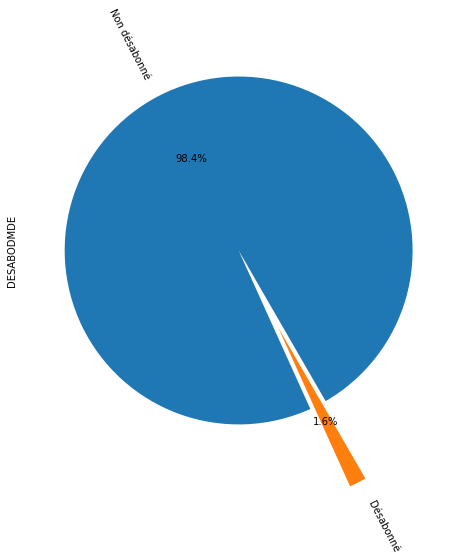

In [65]:
## repartition du "DESABODMDE" 

plt.figure(figsize=(10,8))

df_contact_flag_desabo_anciennete['DESABODMDE'].value_counts(normalize=True).plot(kind='pie', autopct="%.1f%%",explode=[0,0.5],
                            labels=["Non désabonné","Désabonné"],rotatelabels=True,startangle=-60)

In [ ]:
px.box(df_contact_flag_desabo_anciennete,x="Nb_INTER_MAIL_AVANT_DESAB")

In [ ]:
## répartition du nombre de contacts avant désabonnement en fonction des tranches d'ancienneté

pd.crosstab(desabo["Tranche_ct_avant_desabo"],desabo["Tranche_anciennete"], normalize=False,
            margins=True, margins_name="global")

In [ ]:
## répartition du nombre de contacts avant désabonnement en fonction des tranches d'ancienneté en terme de 
## proportion

round(pd.crosstab(desabo["Tranche_ct_avant_desabo"],desabo["Tranche_anciennete"], normalize="columns",
            margins=True, margins_name="%global")*100,2)

On constate que les adhérents de plus de 23 ans d'ancienneté ont tendance a plus se desabonner dès la reception d'au plus 5 contacts(email/sms) contrairement aux adhérent de moins de 23 ans qui supportent plus les contacts (email/sms) avec la MGEN. ils ont tendance à plus se desabonner à partir de 11 conatcts(email/sms) recu. Notons aussi que les adhérents de moins de 12 ans d'ancienneté se désabonne plus que la moyenne à la reception de 5 à 10 contacts(email/sms)

In [ ]:
round(pd.crosstab(desabo["Tranche_ct_avant_desabo"],desabo["Tranche_anciennete"], normalize="index",
            margins=True, margins_name="%global")*100,2)

In [ ]:
## repartition des adhérents ayant reçu 5 contacts, par tranche d'ancienneté 

test = desabo[desabo["Tranche_ct_avant_desabo"]=="moins_5cts"]

pd.crosstab(test["Nb_TOTAL_EMAIL_SMS_AVANT_DESAB"],test["Tranche_anciennete"], margins=True, margins_name="Total")

On constate une répartition assez similaire de part et d'autre du nombre de contact reçu avant désabonnement par tranche d'age

In [ ]:
## ici on va regarder le nombre moyen de contact(email/sms/tel) reçu par chaque tranche d'ancienneté

df_moyen = df_contact_flag_desabo_anciennete.groupby("Tranche_anciennete").agg({"TOTAL_INTER_CANAL":["sum","count"]})

df_moyen.columns = ["_".join(w) for w in list(df_moyen.columns)]

df_moyen["Contact_moyen"] = (np.floor(df_moyen["TOTAL_INTER_CANAL_sum"]/df_moyen["TOTAL_INTER_CANAL_count"])).astype(int)

df_moyen.reset_index(inplace=True)

df_moyen

In [ ]:
## représentation graphique du nombre de contact moyen par classe d'ancienneté

fig = px.bar(df_moyen,x="Tranche_anciennete", y="Contact_moyen", text_auto=True)

fig.show()

On constate que les classes d'ancienneté de 5 à 35 ans sont les plus soliccité. les adhérent avec 51-76 ans d'ancienneté sont les moins sollicités en moyenne.

### Statistque  descriptive du fichier globale

In [2]:
from matplotlib import pyplot

In [162]:
df_contact_flag_desabo_anciennete = pd.read_csv("df_contact_flag_desabo_anciennete_0208.csv", encoding="mbcs",
                                                dtype={"NOIDE":str}, low_memory=False)

[Text(0, 0, 'Contact_Courrier'),
 Text(0, 1, 'Contact_SMS'),
 Text(0, 2, 'Contact_Téléphonique'),
 Text(0, 3, 'Contact_Mail'),
 Text(0, 4, 'Nombre_total_de_Campagne_reçu')]

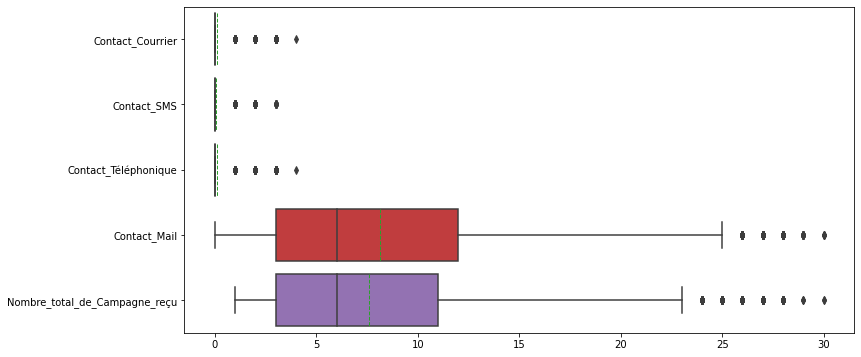

In [18]:
## distribution des differents interaction par cnal dans le fichier

#fig = px.box(df_contact_flag_desabo_anciennete, x=["INTER_COURRIER","INTER_SMS","INTER_MAIL"], orientation='h')

#fig.show()

plt.figure(figsize=(12,6))

sns.boxplot(data=df_contact_flag_desabo_anciennete[["INTER_COURRIER","INTER_SMS","INTER_TEL","INTER_MAIL","Nbre_Total_Camp"]], orient="h",
           showmeans=True,meanline=True)

pyplot.gca().yaxis.set_ticklabels(['Contact_Courrier', 'Contact_SMS', 'Contact_Téléphonique',
                                   'Contact_Mail','Nombre_total_de_Campagne_reçu'])

In [19]:
df_contact_flag_desabo_anciennete[["INTER_COURRIER","INTER_SMS","INTER_TEL","INTER_MAIL","Nbre_Total_Camp"]].describe()

,INTER_COURRIER,INTER_SMS,INTER_TEL,INTER_MAIL,Nbre_Total_Camp
count,160664.000000,160664.000000,160664.000000,160664.000000,160664.000000
mean,0.082769,0.062640,0.120774,8.128747,7.578530
std,0.329728,0.261561,0.356129,6.236508,5.916777
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,3.000000,3.000000
50%,0.000000,0.000000,0.000000,6.000000,6.000000
75%,0.000000,0.000000,0.000000,12.000000,11.000000
max,4.000000,3.000000,4.000000,30.000000,30.000000


In [9]:
df_contact_flag_desabo_anciennete.head()

,NOIDE,DESABODMDE,INTER_COURRIER,INTER_SMS,INTER_MAIL,TOTAL_INTER_CANAL,Nb_SMS_delivre,Nb_email_delivre,nb_clic_email_delivre_36,First_open_email_delivre36_MOD,First_clic_email_delivre36,Latence_open_email_36_MOD,Latence_clic_email_36_MOD,recence_open_email_36_MOD,recence_clic_email_36_MOD,Nb_INTER_MAIL_AFTER_OPEN,Nb_INTER_MAIL_AFTER_CLIC,Nb_INTER_COURRIER_AVANT_DESAB,Nb_INTER_MAIL_AVANT_DESAB,Nb_INTER_SMS_AVANT_DESAB,Nb_TOTAL_EMAIL_SMS_AVANT_DESAB,Flag_desabo_2022,CODSEX,Anciennete,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,Latence_camp,First_INTER_CONTACT_ENTRANT_FORM,First_INTER_COURRIER,First_INTER_MAIL,First_INTER_SMS,First_INTER_TEL,First_Non_reçu,Last_INTER_CONTACT_ENTRANT_FORM,Last_INTER_COURRIER,Last_INTER_MAIL,Last_INTER_SMS,Last_INTER_TEL,Last_Non_reçu,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_Non_reçu,INTER_TEL,Appel_Non_reçu,Nbre_Total_Camp,Nbre_Camp_Conq,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Camp_Hors_Vente,Nbre_Camp_Vente,Age,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,Devis_Protect_Juriq,Devis_Sante_Animale,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nb_INTER_MAIL_AFTER_CLIC_MOD,Nb_Mail_avant_last_open_MoD,Nb_Mail_avant_last_clic_MoD,MIN_TEMPS_ECOULE_CONSE_CLIC,MAX_TEMPS_ECOULE_CONSE_CLIC,MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD,MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD,nb_open_email_delivre_36,Tx_Ouverture,Tx_Clic/recu,Tx_Clic/Ouvert,Tx_decroche,Freq_moy_email/mois,Freq_moy_Cour/mois,Freq_moy_SMS/mois,Freq_moy_TEL/mois,Freq_moy_Camp/mois
0,0100000001,0,0,0,2,2,0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,0,NaN,0,M,0.0,0.0,0.0,1,Plancher,783.00,132,NaN,NaN,2020-09-18,NaN,NaN,NaN,NaN,NaN,2021-01-28,NaN,NaN,NaN,132.0,NaN,NaN,NaN,NaN,0,0,2,0,2,0,2,0,69.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,0.0,331.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0
5,0100013571,0,2,0,7,9,0,7,0.0,2021-01-25,NaN,298.0,NaN,407.0,NaN,2.0,NaN,0,NaN,0,NaN,0,F,3.0,0.0,0.0,0,Forfait,393.00,1047,NaN,2021-01-19,2020-02-26,NaN,NaN,2020-01-09,NaN,2022-11-21,2022-11-10,NaN,NaN,2022-11-09,988.0,671.0,NaN,NaN,1035.0,0,2,10,0,8,2,8,3,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,63.0,231.0,1.0,77.0,3.0,43.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
7,0100013748,0,0,0,1,1,0,1,0.0,2022-10-26,NaN,0.0,NaN,66.0,NaN,1.0,NaN,0,NaN,0,NaN,0,F,1.0,0.0,0.0,0,Forfait,1092.00,0,NaN,NaN,2022-10-31,NaN,NaN,NaN,NaN,NaN,2022-10-31,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,36.0,1.0,100.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,inf
8,0100013774,0,0,0,1,1,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,0,NaN,0,F,3.0,0.0,0.0,0,Forfait,1092.00,0,NaN,NaN,2022-11-15,NaN,NaN,NaN,NaN,NaN,2022-11-15,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,83.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,inf,0.0,0.0,0.0,inf
9,0100014209,0,0,0,10,10,0,10,0.0,2022-05-10,NaN,169.0,NaN,66.0,NaN,1.0,NaN,0,NaN,0,NaN,0,F,2.0,1.0,0.0,0,Taux,1134.84,822,NaN,NaN,2020-08-11,NaN,NaN,NaN,NaN,NaN,2022-11-11,NaN,NaN,NaN,822.0,NaN,NaN,NaN,NaN,0,0,10,0,10,0,10,0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,0.0,142.0,3.0,30.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,1.0


- En ce qui concerne le nombre d'interaction Mail, on observe une distribution presque normale, la moustache inférieur est plus courte que la moustache supérieur ce qui témoigne de la grande densité d'ahérent ayant reçu un nombre de contact email relativement bas. En outre, le premier quartile est de 9, d'ou 25% des adhérents ont reçu environ 9 emails durant les années 2020-2022 contre 75% qui en ont reçu plus de 9 emails. La médiane est quasiment au milieu de la boite et vaut 13, donc 50% d'adhérent ont reçu 13 emails de 2020 à 2022 et 50% plus de 13 emails. Notons aussi un outlier qui a reçu 32 emails sur les 3 dernières années.
- la boite à moustache de l'interaction sms, est trop applati du au à l'echelle, on peut la représenter toute seule afin de l'interprete mais cela ne présentera pas un avantage particulier. En outre, on peut déja retenir qu'il ya pas beaucoup de campagne faisant appel au canal sms, ou du moins les adhérent ne sont pas trop sollicité par le canal sms; car tous les adhérents ont reçu au plus 03 sms sur les 3 dernières années et la plutard d'entre eux n'ont même rien reçu comme sms du tout (quasiment toute la base).
- On observe deux outliers sur les interactions courriers, malgré le fait que les adhérents ne sont pas aussi très sollicité sur ce canal comme ils le sont sur le canal email, on observe quand même une dispersion des individus entre le nombre d'interaction 0 et 2. Mais 50% des adhérents n'ont reçu aucun courrier au cours des 3 dernières années. 25% ont reçu plus de 2 contacts courrier ces 03 dernères années.

In [ ]:
fig = px.box(df_contact_flag_desabo_anciennete, x="Tx_Ouverture", y="CODSEX", 
             orientation="h")

fig.update_traces(boxmean=True)

fig.show()

Text(0, 0.5, '')

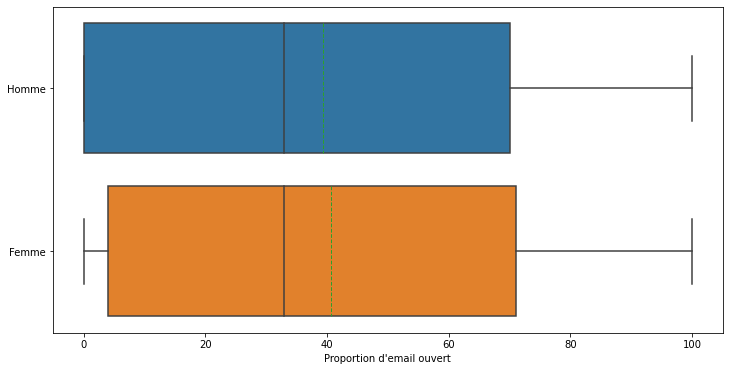

In [92]:
plt.figure(figsize=(12,6))

sns.boxplot(data=df_contact_flag_desabo_anciennete, x="Tx_Ouverture", y="CODSEX", orient="h",
           showmeans=True,meanline=True)

pyplot.gca().yaxis.set_ticklabels(['Homme','Femme'])

plt.xlabel("Proportion d'email ouvert")

plt.ylabel("")

<AxesSubplot:xlabel='INTER_MAIL', ylabel='CODSEX'>

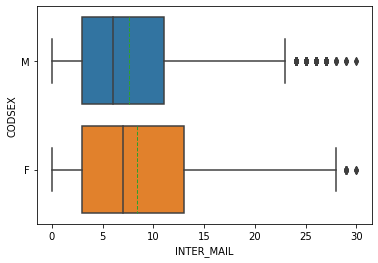

In [10]:
sns.boxplot(data=df_contact_flag_desabo_anciennete, x="INTER_MAIL", y="CODSEX", orient="h",
           showmeans=True,meanline=True)

In [53]:
mannwhitneyu(df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["CODSEX"]=="M")&df_contact_flag_desabo_anciennete["Tx_Ouverture"].notna(),"Tx_Ouverture"],
            df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["CODSEX"]=="F")&df_contact_flag_desabo_anciennete["Tx_Ouverture"].notna(),"Tx_Ouverture"]
             ,alternative="less")

MannwhitneyuResult(statistic=2695858197.5, pvalue=2.054940583115001e-24)

<AxesSubplot:xlabel='Age', ylabel='Tx_Ouverture'>

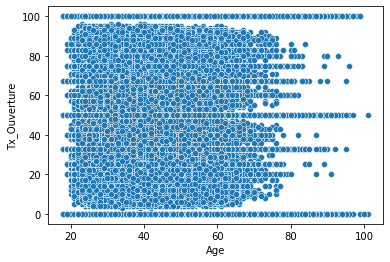

In [56]:
sns.scatterplot(data=df_contact_flag_desabo_anciennete, x="Age",y="Tx_Ouverture")

<AxesSubplot:xlabel='Age', ylabel='Nbre_Total_Camp'>

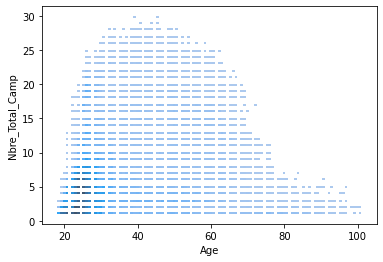

In [33]:
sns.histplot(data=df_contact_flag_desabo_anciennete, x="Age",y="Nbre_Total_Camp")

In [ ]:
## Test de Kolmogorov-Smirnov

stats.kstest(df_contact_flag_desabo_anciennete["INTER_MAIL"],'norm')

### representation du nombre email ouvert et cliqué

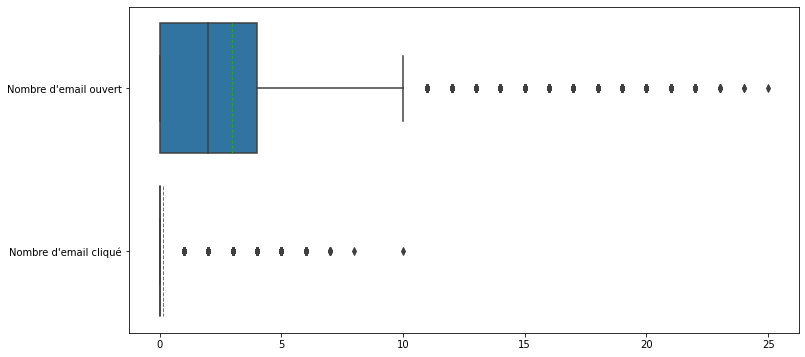

In [107]:
plt.figure(figsize=(12,6))

sns.boxplot(data = df_contact_flag_desabo_anciennete[["nb_open_email_delivre_36","nb_clic_email_delivre_36"]],
           orient="h",showmeans=True,meanline=True)

pyplot.gca().yaxis.set_ticklabels(["Nombre d'email ouvert","Nombre d'email cliqué"])

plt.show()

In [110]:
df_contact_flag_desabo_anciennete[["nb_open_email_delivre_36","nb_clic_email_delivre_36","Age"]].describe()

,nb_open_email_delivre_36,nb_clic_email_delivre_36,Age
count,158921.000000,158921.000000,160664.000000
mean,2.979329,0.141825,37.267845
std,3.475995,0.458774,14.494440
min,0.000000,0.000000,18.000000
25%,0.000000,0.000000,26.000000
50%,2.000000,0.000000,32.000000
75%,4.000000,0.000000,47.000000
max,25.000000,10.000000,101.000000


In [ ]:
#%matplotlib notebook

sns.displot(data=df_contact_flag_desabo_anciennete, x="INTER_MAIL",kde=True)

plt.show()

On contacte une grande dispertion du nombre d'ouverture par rapport au nombre de clic, comme quoi un adhérent peut faire plusieurs ouverture sans jamais avoir à cliquer. On observe tout de même un grand nombre d'outliers sur les deux variables, mais cela n'est pas forcément aberrant car tous les adhérents ne sont pas ciblés de la même façon, il peut avoir des adhérents qui sont généralement plus ciblés que les autres cela dépend dus campagnes et canal que l'on souhaite utiliser pour la campagne; ce qui peux expliquer les ces outliers.

### distribution de l'ancienneté

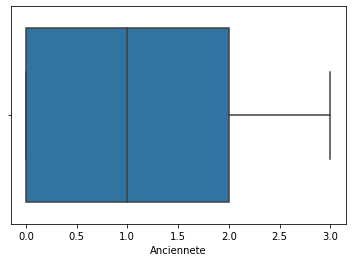

In [19]:
sns.boxplot(data = df_contact_flag_desabo_anciennete,x="Anciennete",
           orient="h")
plt.show()

## Analyse de la base des adhérent ayant recu au moins un email

In [ ]:

df_ouvreur = df_contact_flag_desabo_anciennete[["INTER_MAIL","nb_open_email_delivre_36",
                                               "nb_clic_email_delivre_36"]].groupby(["INTER_MAIL",
                                                                                     "nb_open_email_delivre_36","nb_clic_email_delivre_36"],as_index=True, group_keys=False).agg({"nb_open_email_delivre_36":"count",
                                                                                     "nb_clic_email_delivre_36":"count"})

df_ouvreur.rename(columns={"nb_open_email_delivre_36":"Nb_adh_ouv","nb_clic_email_delivre_36":"nb_adh_clic"}, inplace=True)

df_ouvreur.reset_index(inplace=True)

df_ouvreur

In [ ]:
def tx_au_moins_ouvreur(df,col1,col2):
    
    """
    Cette fonction permettra de calculer le taux d'adhérent ayant ouvert plus la moitié des emails qu'ils ont reçu
    
    au cours des 3 dernières années.
    
    Ainsi que le taux d'adhérent ayant cliqué au moins une fois sur les email qu'ils ont ouvert 
    """

    nbre_email = list(df["INTER_MAIL"].unique())
    
    tx=[(0,0,16081)]

    for nbre in nbre_email[1:]:

        nb = (df.loc[(df["INTER_MAIL"]==nbre)&(df[col1]>=np.ceil(nbre/2)),col2].sum() if col1=="nb_open_email_delivre_36"
             else df.loc[(df["INTER_MAIL"]==nbre)&(df["nb_open_email_delivre_36"]>=1)&(df[col1]>=1),col2].sum())
        
        nb_total = (df.loc[(df["INTER_MAIL"]==nbre),col2].sum() if col1=="nb_open_email_delivre_36" 
                   else df.loc[(df["INTER_MAIL"]==nbre)&(df["nb_open_email_delivre_36"]>=1),col2].sum())

        tx.append((nbre,round(nb/nb_total,2)*100,nb_total))
        
    return tx

In [ ]:
## Appel de fonction pour calculer le taux d'ouvreur

df_test_ouvreur = pd.DataFrame(tx_au_moins_ouvreur(df_ouvreur,"nb_open_email_delivre_36","Nb_adh_ouv"), columns=["INTER_MAIL","Taux_ouvreur","Nb_adh_ouv"])

df_test_ouvreur.head()

In [ ]:
## Appel de fonction pour calculer le taux de cliqueur

df_test_cliqueur = pd.DataFrame(tx_au_moins_ouvreur(df_ouvreur,"nb_clic_email_delivre_36","nb_adh_clic"), columns=["INTER_MAIL","Taux_cliqueur","nb_adh_clic"])

df_test_cliqueur.head()

In [ ]:
#%matplotlib notebook
ax = sns.countplot(data=df_contact_flag_desabo_anciennete, x="INTER_MAIL",color="blue")

ax2 = ax.twinx()

sns.lineplot(data=df_test_ouvreur, x="INTER_MAIL",y="Taux_ouvreur",color="red")

sns.lineplot(data=df_test_cliqueur, x="INTER_MAIL",y="Taux_cliqueur",color="black")

plt.ylabel("Taux")

plt.show()

## les adhérents ouvrent de moins en moins d'email, donc plus ils recoivent d'email moins ils ouvrent

On constate que le taux des adhérents ayant ouvert au moins la moitié des email reçu décroit avec le nombre d'email reçu, en d'autre terme un adhérent a plus de change d'ouvrir des emails s'il en reçoit moins.
Le taux d'adherent ayant au moins cliquer une fois sur les emails ouvert a une allure de croissance lente, ce qui signifie que plus un adhérent reçoit d'email plus il a de chance de cliquer au moins sur un emails parmi ceux qu'il decide d'ouvrir
- Conclusion: Plus les adhérents reçoivent d'email moins on a de chance qu'ils les ouvrent, mais une fois ouvert on a plus de chance qu'ils cliquent au moins sur un d'entre eux. Donc le contenu des emails envoyés peut sembler interessant et bien fait.

In [65]:
#pd.qcut(df_contact_flag_desabo_anciennete["Tx_Ouverture"],6,duplicates="drop")

## Discrétisation des variables

In [132]:
df_contact_flag_desabo_anciennete["INTER_MAIL_disc"]=df_contact_flag_desabo_anciennete["INTER_MAIL"].apply(lambda x: 
                                                    "jamais_cib_mail" if x==0 else "1_3_mails" if 0<x<=3 else "4_5_mails" if 3<x<=5
                                                    else "6_8_mails" if 5<x<=8 else "9_11_mails" if 8<x<=11 else "12_16_mails" if 11<x<=16
                                                    else "17_mails_et_plus")

df_contact_flag_desabo_anciennete["INTER_MAIL_bis_disc"]=df_contact_flag_desabo_anciennete["INTER_MAIL"].apply(lambda x: 
                                                    "jamais_cib_mail" if x==0 else "1_3_mails" if 0<x<=3 else "4_mails" if x==4
                                                    else "5_mails" if x==5 else "6_8_mails" if 6<=x<=8 else "9_11_mails" if 9<=x<=11
                                                    else "12_16_mails" if 12<=x<=16 else "17_mails_et_plus")


df_contact_flag_desabo_anciennete["INTER_TEL_disc"] = df_contact_flag_desabo_anciennete["INTER_TEL"].apply(lambda x: 
                                                    "Aucun_Tel_dec" if x==0 else "Au_moins_1_tel_dec")

#df_contact_flag_desabo_anciennete["Tx_decroche_disc"] = pd.qcut(df_contact_flag_desabo_anciennete["Tx_decroche"],6,labels = ["moins_50%","plus_50%"],duplicates="drop")

df_contact_flag_desabo_anciennete["INTER_SMS_disc"] = df_contact_flag_desabo_anciennete["INTER_SMS"].apply(lambda x:"Aucun_SMS" if x==0 else "au_moins_1SMS" if x>=1 else x)

df_contact_flag_desabo_anciennete["INTER_COURRIER_disc"] = df_contact_flag_desabo_anciennete["INTER_COURRIER"].apply(lambda x:"Aucun_Cour" if x==0 else "au_moins_1Cour" if x>=1 else x)

df_contact_flag_desabo_anciennete["Total_Contact_disc"]=pd.qcut(df_contact_flag_desabo_anciennete["TOTAL_INTER_CANAL"],6, labels=["moins_3_cts", "3_5_cts","5_9_cts",
                                                                  "9_12_cts","12_17_cts","plus_17_cts"],duplicates="drop")

df_contact_flag_desabo_anciennete["nb_clic_disc"] = df_contact_flag_desabo_anciennete["nb_clic_email_delivre_36"].apply(lambda x:"Aucun_Clic" if x==0 else "1_2clic" if x==1 or x==2 else "plus_3_clic" if x>=3 else x)

#df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"]= pd.qcut(df_contact_flag_desabo_anciennete["Tx_Ouverture"],6, labels=["moins_11%", "11_27%","27_50%","50_75%","75_100%"],duplicates="drop")

df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"] = df_contact_flag_desabo_anciennete["Tx_Ouverture"].apply(lambda x:"moins_11%" if 0<x<=11 else "11_27%" if 11<x<=27
                                                                                                                else "27_50%" if 24<x<=50 else "50_75%" if 50<x<=75 else
                                                                                                                "75_100%" if 75<x<=100 else x)

df_contact_flag_desabo_anciennete["nb_open_email_disc"]= df_contact_flag_desabo_anciennete["nb_open_email_delivre_36"].apply(lambda x:"Aucun_open" if x==0 
                                                                                                                             else "1_2_open" if 1<=x<=2 else "3_4_open" if 3<=x<=4 else "5_8_open"
                                                                                                                                    if 5<=x<=8 else "plus_8_open" if x>8 else x)
df_contact_flag_desabo_anciennete["Freq_moy_email/mois_disc"]= df_contact_flag_desabo_anciennete["Freq_moy_email/mois"].apply(lambda x:"Aucun_mail/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "1_mail/mois" if x==1 else "plus_2mails/mois"
                                                                                                                             if x>=2 else x)
df_contact_flag_desabo_anciennete["Freq_moy_Cour/mois_disc"]= df_contact_flag_desabo_anciennete["Freq_moy_Cour/mois"].apply(lambda x:"Aucun_Cour/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "plus_1_Cour/mois" if x>=1 else x)
df_contact_flag_desabo_anciennete["Freq_moy_SMS/mois_disc"]= df_contact_flag_desabo_anciennete["Freq_moy_SMS/mois"].apply(lambda x:"Aucun_SMS/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "au_moins_1_SMS/mois" if x>=1 else x)
                                                                                                                             
df_contact_flag_desabo_anciennete["Freq_moy_TEL/mois_disc"]= df_contact_flag_desabo_anciennete["Freq_moy_TEL/mois"].apply(lambda x:"Aucun_TEL/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "plus_1_TEL/mois" if x>=1 else x)
df_contact_flag_desabo_anciennete["Freq_moy_Camp/mois_disc"]= df_contact_flag_desabo_anciennete["Freq_moy_Camp/mois"].apply(lambda x:"1_Camp/mois" if x==1
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "plus_2_Camp/mois" if x>=2 else x)
df_contact_flag_desabo_anciennete["Tx_Clic/recu_disc"]= df_contact_flag_desabo_anciennete["Tx_Clic/recu"].apply(lambda x:"jamais_cliquer" if x==0
                                                                                                    else "moins_20%_clic" if 0<x<=20 else "20_50%_clic" if 20<x<=50
                                                                                                     else "plus_50%_clic" if x>50 else x)

df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert_disc"]= df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert"].apply(lambda x:"0%_clic/ouvert" if x==0
                                                                                                    else "1_25%_clic/ouvert" if 1<=x<=25 else "26_50%_clic/ouvert" if 26<=x<=50
                                                                                                     else "51_75%_clic/ouvert" if 51<=x<=75 else "plus_75%_clic/ouvert" if x>75
                                                                                                                    else x)


df_contact_flag_desabo_anciennete["Nb_mail_last_open_disc"]= df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_open_MoD"].apply(lambda x:"Aucun_mail" if x==0
                                                                                                    else "1_5_mail" if 1<=x<=5 else "6_10_mail" if 6<=x<=10
                                                                                                     else "plus_10_mail" if x>10 else x)

df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc"]= df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_clic_MoD"].apply(lambda x:"Aucun_mail" if x==0 else "1_4_mails" if 1<=x<=4
                                                                                                    else "5_10_mail" if 5<=x<=10 else "plus_10_mails" if x>10
                                                                                                      else x)
 
#df_contact_flag_desabo_anciennete["Tranche_anciennete"]=pd.qcut(df_contact_flag_desabo_anciennete["Anciennete"],6,
#                                                                labels=["moins_5ans","5_12ans","12_23ans",
#                                                                       "23_35ans","35_51ans","51_76ans"])



In [133]:
## liste des variables discrétisées ayant des valeurs manquantes

[col for col in df_contact_flag_desabo_anciennete.columns if df_contact_flag_desabo_anciennete[col].isna().sum()>0 and col.endswith("disc")]

['nb_clic_disc',
 'Tx_Ouverture_disc',
 'nb_open_email_disc',
 'Tx_Clic/recu_disc',
 'Tx_Clic/Ouvert_disc',
 'Nb_mail_last_clic_disc']

In [117]:
def drop_col(df,col,replace="NC"):
    
    df[col] = df[col].astype(str)
    
    df.loc[df[col]!="nan", col+"_MoD"] = df.loc[df[col]!="nan", col]
    
    df[col+"_MoD"].fillna(replace, inplace=True)
    
    df.drop(col, axis=1, inplace=True)
    
    df.rename(columns={col+"_MoD":col}, inplace=True)
    
    return df

In [23]:
#df_contact_flag_desabo_anciennete[(df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert_disc"]=="jamais_ouvert/cliquer")&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0)]["Tx_Ouverture_disc"].value_counts(dropna=False)

In [134]:
## Pour la variable Tx_Ouverture_disc, on constate que toute les lignes ou il ya les NaN sont celle n'ayant pas de date de 
## d'ouverture dont ce sont les lignes sans ouverture 

print(df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"].isna()&df_contact_flag_desabo_anciennete["First_open_email_delivre36_MOD"].isna()].shape)

## Remplacement des NaN par "jamais ouvert"

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"Tx_Ouverture_disc_MOD"]="jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"].isin([np.nan,0])&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"Tx_Ouverture_disc_MOD"]="jamais_ouvert"

df_contact_flag_desabo_anciennete["Tx_Ouverture_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"], inplace=True)


## Remplacer les NaN de "Tx_decroche_disc" par "jamais_cib_TEL" car "INTER_TEL" est null

#drop_col(df_contact_flag_desabo_anciennete,"Tx_decroche_disc",replace="jamais_cib_TEL")

## Remplacement des NaN par "jamais_cliquer" car ces adhérents n'ont jamais eu à cliquer du fait du non reseignement 
## des date de clic


df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"Nb_mail_last_clic_disc_MOD"]="jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"Nb_mail_last_clic_disc_MOD"]="jamais_cliquer"

df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc"], inplace=True)


## remplacer les NaN par "jamais_cliquer" car la date d'ouverture est vide sur la colonne "Tx_Clic/Ouvert_disc"
## pour tous ces adhérents

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"Tx_Clic/Ouvert_disc_MOD"]="jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"Tx_Clic/Ouvert_disc_MOD"]="jamais_ouvert/cliquer"

df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert_disc"], inplace=True)



## Remplacer les NaN par "jamais_cliquer" sur la variable "nb_clic_disc" car "First_clic_email_delivre36" est vide
## pour tous ces adhérents

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["nb_clic_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"nb_clic_disc_MOD"]="jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["nb_clic_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"nb_clic_disc_MOD"]="jamais_cliquer"

df_contact_flag_desabo_anciennete["nb_clic_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["nb_clic_disc"], inplace=True)


#df_contact_flag_desabo_anciennete["nb_clic_disc"].fillna("jamais_cliquer", inplace=True)

## Remplacer les NaN par "jamais_ouvert" sur la variable "nb_open_email_disc" car "First_open_email_delivre36_MOD" est vide
## pour tous ces adhérents

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["nb_open_email_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"nb_open_email_disc_MOD"]="jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["nb_open_email_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"nb_open_email_disc_MOD"]="jamais_ouvert"

df_contact_flag_desabo_anciennete["nb_open_email_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["nb_open_email_disc"], inplace=True)


#df_contact_flag_desabo_anciennete["nb_open_email_disc"].fillna("jamais_ouvert", inplace=True)

## Remplacer les NaN par "jamais_cliquer" sur la variable "Tx_Clic/recu_disc" car "First_clic_email_delivre36" est vide
## pour tous ces adhérents

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Tx_Clic/recu_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"Tx_Clic/recu_disc_MOD"]="jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Tx_Clic/recu_disc"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"Tx_Clic/recu_disc_MOD"]="jamais_cliquer"

df_contact_flag_desabo_anciennete["Tx_Clic/recu_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["Tx_Clic/recu_disc"], inplace=True)

df_contact_flag_desabo_anciennete.drop(["Tx_Clic/recu_disc","nb_open_email_disc","nb_clic_disc","Tx_Clic/Ouvert_disc",
                                       "Nb_mail_last_clic_disc","Tx_Ouverture_disc"], axis=1,inplace=True)

df_contact_flag_desabo_anciennete.rename(columns={"Tx_Ouverture_disc_MOD":"Tx_Ouverture_disc","Nb_mail_last_clic_disc_MOD":"Nb_mail_last_clic_disc",
                                                 "Tx_Clic/Ouvert_disc_MOD":"Tx_Clic/Ouvert_disc","nb_clic_disc_MOD":"nb_clic_disc",
                                                 "nb_open_email_disc_MOD":"nb_open_email_disc","Tx_Clic/recu_disc_MOD":"Tx_Clic/recu_disc"},inplace=True)

(1743, 114)


### Ne pas executer ici

In [ ]:
## discrétisation des temps écoulés entre ds ouvertures et clics consécutifs

df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"] = df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD"].apply(lambda x:
                                                                     "même_jr" if x==0 else "1_jr" if x==1 else "2_7_jrs" if 2<=x<=7 else "8_22_jrs" if 8<=x<=22
                                                                    else "au_moins_23jrs" if x>=23 else x)

df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc"] = pd.qcut(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD"],6,labels=["moins_51_jrs",
                                                                    "52_82_jrs","83_128_jrs","129_192_jrs","193_310_jrs","plus_310_jrs"],duplicates="drop")

df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc"] = pd.qcut(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC"],6,labels=["moins_5_jrs","6_13_jrs",
                                                                        "14_29_jrs","30_77_jrs","78_230_jrs","231_1093_jrs"],duplicates="drop")

df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc"] = pd.qcut(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC"],6,labels=["moins_141_jrs","142_215_jrs",
                                                                        "216_287_jrs","288_364_jrs","365_503_jrs","503_1093_jrs"],duplicates="drop")

## discrétisation de la récence

df_contact_flag_desabo_anciennete["recence_open_email_36_disc"] = pd.qcut(df_contact_flag_desabo_anciennete["recence_open_email_36_MOD"],6,
                                                                 labels=["4_65_jrs","65_66_jrs","67_100_jrs","101_234_jrs","235_478_jrs","478_1094_jrs"], duplicates="drop")

df_contact_flag_desabo_anciennete["recence_clic_email_36_disc"] = pd.qcut(df_contact_flag_desabo_anciennete["recence_clic_email_36_MOD"],6,
                                                                 labels=["4_66_jrs","67_234_jrs","235_444_jrs","445_549_jrs","550_838_jrs","839_1094_jrs"], duplicates="drop")


In [26]:
## Gestion des valeurs manquantes sur "MIN_TEMPS_ECOULE_CONSE_OUVERT_disc" 

df_contact_flag_desabo_anciennete["recence_open_email_36_disc"] = df_contact_flag_desabo_anciennete["recence_open_email_36_disc"].astype(str)

df_contact_flag_desabo_anciennete["recence_clic_email_36_disc"] = df_contact_flag_desabo_anciennete["recence_clic_email_36_disc"].astype(str)

df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"] = df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"].astype(str)

df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc"] = df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc"].astype(str)

df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc"] = df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc"].astype(str)

df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc"] = df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc"].astype(str)



df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"]=="nan") & df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"].isna() & (df_contact_flag_desabo_anciennete["INTER_MAIL"]==0) ,"MIN_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"] = "jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"]=="nan") & df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"].isna() & (df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0) ,"MIN_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"] = "jamais_ouvert"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"]=="nan") & (df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"]==0) ,"MIN_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"] = "ouvert_1_fois"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"]=="nan") & (~df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"].isin([np.nan,0])) & (df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0) ,"MIN_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"] = "NA"

df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"], inplace=True)

## Gestion des valeurs manquantes sur "MIN_TEMPS_ECOULE_CONSE_OUVERT_disc" 

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc"]=="nan") & df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"].isna() & (df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"MAX_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"] = "jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc"]=="nan") & df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"].isna() & (df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0) ,"MAX_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"] = "jamais_ouvert"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc"]=="nan") & (df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"]==0) ,"MAX_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"] = "ouvert_1_fois"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc"]=="nan") & (~df_contact_flag_desabo_anciennete["Latence_open_email_36_MOD"].isin([np.nan,0]))&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0) ,"MAX_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"] = "NA"

df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_OUVERT_disc"], inplace=True)

## Gestion des valeurs manquantes sur "MIN_TEMPS_ECOULE_CONSE_CLIC_disc" 

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc"]=="nan") & df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0) ,"MIN_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"] = "jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc"]=="nan") & df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0) ,"MIN_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"] = "jamais_cliquer"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc"]=="nan") & (df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"]==0) ,"MIN_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"] = "cliquer_1_fois"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc"]=="nan") & (~df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"].isin([np.nan,0]))&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0) ,"MIN_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"] = "NA"

df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_CLIC_disc"], inplace=True)

## Gestion des valeurs manquantes sur "MAX_TEMPS_ECOULE_CONSE_CLIC_disc" 

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc"]=="nan") & df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0) ,"MAX_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"] = "jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc"]=="nan") & df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"].isna()&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0) ,"MAX_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"] = "jamais_cliquer"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc"]=="nan") & (df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"]==0) ,"MAX_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"] = "cliquer_1_fois"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc"]=="nan") & (~df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"].isin([np.nan,0]))&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"MAX_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"] = "NA"

df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["MAX_TEMPS_ECOULE_CONSE_CLIC_disc"], inplace=True)

## Gestion des valeurs manquantes sur "recence_open_email_36_disc"

#df_contact_flag_desabo_anciennete["recence_open_email_36_disc"].fillna("jamais_ouvert", inplace=True)

#drop_col(df_contact_flag_desabo_anciennete,"recence_open_email_36_disc",replace="jamais_ouvert")


df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["recence_open_email_36_disc"]=="nan")&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"recence_open_email_36_disc_MOD"]="jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["recence_open_email_36_disc"]=="nan")&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"recence_open_email_36_disc_MOD"]="jamais_ouvert"

df_contact_flag_desabo_anciennete["recence_open_email_36_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["recence_open_email_36_disc"], inplace=True)

## car tous les adhérents ayant "recence_open_email_36_disc" NaN ont aussi "First_open_email_delivre36_MOD" à NaN

## Gestion des valeurs manquantes sur "recence_clic_email_36_disc"

#df_contact_flag_desabo_anciennete["recence_clic_email_36_disc"].fillna("jamais_cliquer", inplace=True)

#drop_col(df_contact_flag_desabo_anciennete,"recence_clic_email_36_disc",replace="jamais_cliquer")

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["recence_clic_email_36_disc"]=="nan")&(df_contact_flag_desabo_anciennete["INTER_MAIL"]==0),"recence_clic_email_36_disc_MOD"]="jamais_cib_mail"

df_contact_flag_desabo_anciennete.loc[(df_contact_flag_desabo_anciennete["recence_clic_email_36_disc"]=="nan")&(df_contact_flag_desabo_anciennete["INTER_MAIL"]!=0),"recence_clic_email_36_disc_MOD"]="jamais_ouvert"

df_contact_flag_desabo_anciennete["recence_clic_email_36_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["recence_clic_email_36_disc"], inplace=True)

## car tous les adhérents ayant "recence_clic_email_36_disc" NaN ont aussi "First_clic_email_delivre36_MOD" à NaN

df_contact_flag_desabo_anciennete.drop(["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc","MAX_TEMPS_ECOULE_CONSE_OUVERT_disc",
                                       "MIN_TEMPS_ECOULE_CONSE_CLIC_disc","MAX_TEMPS_ECOULE_CONSE_CLIC_disc"],axis=1,inplace=True)

df_contact_flag_desabo_anciennete.rename(columns={"MIN_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD":"MIN_TEMPS_ECOULE_CONSE_OUVERT_disc",
                                                 "MAX_TEMPS_ECOULE_CONSE_OUVERT_disc_MOD":"MAX_TEMPS_ECOULE_CONSE_OUVERT_disc",
                                                 "MIN_TEMPS_ECOULE_CONSE_CLIC_disc_MOD":"MIN_TEMPS_ECOULE_CONSE_CLIC_disc",
                                                 "MAX_TEMPS_ECOULE_CONSE_CLIC_disc_MOD":"MAX_TEMPS_ECOULE_CONSE_CLIC_disc"},inplace=True)

df_contact_flag_desabo_anciennete.drop(["recence_open_email_36_disc","recence_clic_email_36_disc"],axis=1,inplace=True)

df_contact_flag_desabo_anciennete.rename(columns={"recence_open_email_36_disc_MOD":"recence_open_email_36_disc",
                                                 "recence_clic_email_36_disc_MOD":"recence_clic_email_36_disc"}, inplace=True)

### Continuer l'execution

In [ ]:
#df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"].value_counts(dropna=False)

In [ ]:
#Liste_disc = [col for col in df_contact_flag_desabo_anciennete.columns if col.endswith("disc")] + ["DESABODMDE","Flag_desabo_2022"]

## Expoprt du fichier pour analyse

#df_contact_flag_desabo_anciennete[Liste_disc].to_csv(r"C:\Users\pkamga\Documents\Etude_pression_Com\df_contact_flag_desabo_anciennete_0106.csv",index=False)

In [83]:
## Liste des variables sur lesquelles sera concentrée l'étude

Liste_disc =["INTER_MAIL","TOTAL_INTER_CANAL",'nb_open_email_delivre_36',
       'Tx_Ouverture', 'Tx_Clic/recu', 'Tx_Clic/Ouvert','nb_clic_email_delivre_36'] + [col for col in df_contact_flag_desabo_anciennete.columns if col.endswith("disc")] + ["DESABODMDE","Flag_desabo_2022"]

Liste_disc

['INTER_MAIL',
 'TOTAL_INTER_CANAL',
 'nb_open_email_delivre_36',
 'Tx_Ouverture',
 'Tx_Clic/recu',
 'Tx_Clic/Ouvert',
 'nb_clic_email_delivre_36',
 'INTER_MAIL_disc',
 'INTER_MAIL_bis_disc',
 'INTER_TEL_disc',
 'INTER_SMS_disc',
 'INTER_COURRIER_disc',
 'Total_Contact_disc',
 'Freq_moy_email/mois_disc',
 'Freq_moy_Cour/mois_disc',
 'Freq_moy_SMS/mois_disc',
 'Freq_moy_TEL/mois_disc',
 'Freq_moy_Camp/mois_disc',
 'Nb_mail_last_open_disc',
 'Tx_Ouverture_disc',
 'Nb_mail_last_clic_disc',
 'Tx_Clic/Ouvert_disc',
 'nb_clic_disc',
 'nb_open_email_disc',
 'Tx_Clic/recu_disc',
 'DESABODMDE',
 'Flag_desabo_2022']

In [12]:
## Répartition de "Tx_Ouverture_disc"

df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"].value_counts(dropna=False)

jamais_ouvert      66130
75_100%            51734
27_50%             40015
11_27%             26243
50_75%             25033
moins_11%           9590
jamais_cib_mail     1400
Name: Tx_Ouverture_disc, dtype: int64

In [62]:
df_contact_flag_desabo_anciennete.head()

,NOIDE,DESABODMDE,INTER_COURRIER,INTER_SMS,INTER_MAIL,TOTAL_INTER_CANAL,Nb_SMS_delivre,Nb_email_delivre,nb_clic_email_delivre_36,First_open_email_delivre36_MOD,First_clic_email_delivre36,Latence_open_email_36_MOD,Latence_clic_email_36_MOD,recence_open_email_36_MOD,recence_clic_email_36_MOD,Nb_INTER_MAIL_AFTER_OPEN,Nb_INTER_MAIL_AFTER_CLIC,Nb_INTER_COURRIER_AVANT_DESAB,Nb_INTER_MAIL_AVANT_DESAB,Nb_INTER_SMS_AVANT_DESAB,Nb_TOTAL_EMAIL_SMS_AVANT_DESAB,Flag_desabo_2022,CODSEX,Anciennete,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,Latence_camp,First_INTER_CONTACT_ENTRANT_FORM,First_INTER_COURRIER,First_INTER_MAIL,First_INTER_SMS,First_INTER_TEL,First_Non_reçu,Last_INTER_CONTACT_ENTRANT_FORM,Last_INTER_COURRIER,Last_INTER_MAIL,Last_INTER_SMS,Last_INTER_TEL,Last_Non_reçu,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_Non_reçu,INTER_TEL,Appel_Non_reçu,Nbre_Total_Camp,Nbre_Camp_Conq,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Camp_Hors_Vente,Nbre_Camp_Vente,Age,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,Devis_Protect_Juriq,Devis_Sante_Animale,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nb_INTER_MAIL_AFTER_CLIC_MOD,Nb_Mail_avant_last_open_MoD,Nb_Mail_avant_last_clic_MoD,MIN_TEMPS_ECOULE_CONSE_CLIC,MAX_TEMPS_ECOULE_CONSE_CLIC,MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD,MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD,nb_open_email_delivre_36,Tx_Ouverture,Tx_Clic/recu,Tx_Clic/Ouvert,Tx_decroche,Freq_moy_email/mois,Freq_moy_Cour/mois,Freq_moy_SMS/mois,Freq_moy_TEL/mois,Freq_moy_Camp/mois,INTER_MAIL_disc,INTER_MAIL_bis_disc,INTER_TEL_disc,INTER_SMS_disc,INTER_COURRIER_disc,Total_Contact_disc,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,Nb_mail_last_open_disc,Tx_Ouverture_disc,Nb_mail_last_clic_disc,Tx_Clic/Ouvert_disc,nb_clic_disc,nb_open_email_disc,Tx_Clic/recu_disc
0,0100000001,0,0,0,2,2,0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,0,NaN,0,M,0.0,0.0,0.0,1,Plancher,783.00,132,NaN,NaN,2020-09-18,NaN,NaN,NaN,NaN,NaN,2021-01-28,NaN,NaN,NaN,132.0,NaN,NaN,NaN,NaN,0,0,2,0,2,0,2,0,69.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,0.0,331.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0,moins_3_mails,moins_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,1_5_mail,jamais_ouvert,jamais_cliquer,jamais_ouvert/cliquer,Aucun_Clic,Aucun_open,jamais_cliquer
5,0100013571,0,2,0,7,9,0,7,0.0,2021-01-25,NaN,298.0,NaN,407.0,NaN,2.0,NaN,0,NaN,0,NaN,0,F,3.0,0.0,0.0,0,Forfait,393.00,1047,NaN,2021-01-19,2020-02-26,NaN,NaN,2020-01-09,NaN,2022-11-21,2022-11-10,NaN,NaN,2022-11-09,988.0,671.0,NaN,NaN,1035.0,0,2,10,0,8,2,8,3,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,63.0,231.0,1.0,77.0,3.0,43.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,5_8_mails,6_8_mails,Aucun_Tel_dec,Aucun_SMS,au_moins_1Cour,9_12_cts,1_mail/mois,plus_1_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,1_5_mail,27_50%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,3_4_open,jamais_cliquer
7,0100013748,0,0,0,1,1,0,1,0.0,2022-10-26,NaN,0.0,NaN,66.0,NaN,1.0,NaN,0,NaN,0,NaN,0,F,1.0,0.0,0.0,0,Forfait,1092.00,0,NaN,NaN,2022-10-31,NaN,NaN,NaN,NaN,NaN,2022-10-31,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,36.0,1.0,100.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,inf,moins_3_mails,moins_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,ciblé_1_fois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,ciblé_1_fois,Aucun_mail,75_100%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,1_2_open,jamais_cliquer
8,0100013774,0,0,0,1,1,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,

In [136]:
## data frame avec les colonnes neccessaires pour l'étude

df_test = df_contact_flag_desabo_anciennete[Liste_disc].copy()

In [102]:
df_test["Tx_Ouverture_disc"].value_counts(normalize=True)

jamais_ouvert      0.300393
75_100%            0.235000
27_50%             0.181767
11_27%             0.119208
50_75%             0.113711
moins_11%          0.043562
jamais_cib_mail    0.006359
Name: Tx_Ouverture_disc, dtype: float64

In [140]:
df_test_anc = df_test[df_test["Tx_Ouverture"].notna()].copy()

df_test_anc

,INTER_MAIL,TOTAL_INTER_CANAL,nb_open_email_delivre_36,Tx_Ouverture,Tx_Clic/recu,Tx_Clic/Ouvert,nb_clic_email_delivre_36,INTER_MAIL_disc,INTER_MAIL_bis_disc,INTER_TEL_disc,INTER_SMS_disc,INTER_COURRIER_disc,Total_Contact_disc,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,Nb_mail_last_open_disc,Tx_Ouverture_disc,Nb_mail_last_clic_disc,Tx_Clic/Ouvert_disc,nb_clic_disc,nb_open_email_disc,Tx_Clic/recu_disc,DESABODMDE,Flag_desabo_2022
0,2,2,0.0,0.0,0.0,NaN,0.0,1_3_mails,1_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,1_5_mail,jamais_ouvert,jamais_cliquer,jamais_ouvert/cliquer,Aucun_Clic,Aucun_open,jamais_cliquer,0,0
5,7,9,3.0,43.0,0.0,0.0,0.0,6_8_mails,6_8_mails,Aucun_Tel_dec,Aucun_SMS,au_moins_1Cour,9_12_cts,1_mail/mois,plus_1_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,1_5_mail,27_50%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,3_4_open,jamais_cliquer,0,0
7,1,1,1.0,100.0,0.0,0.0,0.0,1_3_mails,1_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,ciblé_1_fois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,ciblé_1_fois,Aucun_mail,75_100%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,1_2_open,jamais_cliquer,0,0
8,1,1,0.0,0.0,0.0,NaN,0.0,1_3_mails,1_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,ciblé_1_fois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,ciblé_1_fois,Aucun_mail,jamais_ouvert,jamais_cliquer,jamais_ouvert/cliquer,Aucun_Clic,Aucun_open,jamais_cliquer,0,0
9,10,10,3.0,30.0,0.0,0.0,0.0,9_11_mails,9_11_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,9_12_cts,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,6_10_mail,27_50%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,3_4_open,jamais_cliquer,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220139,11,13,8.0,73.0,0.0,0.0,0.0,9_11_mails,9_11_mails,Aucun_Tel_dec,Aucun_SMS,au_moins_1Cour,12_17_cts,1_mail/mois,plus_1_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,6_10_mail,50_75%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,5_8_open,jamais_cliquer,0,0
220140,10,10,0.0,0.0,0.0,NaN,0.0,9_11_mails,9_11_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,9_12_cts,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,6_10_mail,jamais_ouvert,jamais_cliquer,jamais_ouvert/cliquer,Aucun_Clic,Aucun_open,jamais_cliquer,0,0
220141,14,14,13.0,93.0,0.0,0.0,0.0,12_16_mails,12_16_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,12_17_cts,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,plus_10_mail,75_100%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,plus_8_open,jamais_cliquer,0,0
220142,1,1,1.0,100.0,0.0,0.0,0.0,1_3_mails,1_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,ciblé_1_fois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,ciblé_1_fois,Aucun_mail,75_100%,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,1_2_open,jamais_cliquer,0,0


In [ ]:
df_hist = pd.crosstab(df_test["INTER_MAIL_disc"],df_test["Tx_Ouverture_disc"],normalize="columns")

df_hist

In [15]:
pd.crosstab(df_test["Tx_Clic/Ouvert_disc"],df_test["Tx_Ouverture_disc"],normalize="columns",margins=True,margins_name="%Global")

Tx_Ouverture_disc,11_27%,27_50%,50_75%,75_100%,jamais_cib_mail,jamais_ouvert,moins_11%,%Global
Tx_Clic/Ouvert_disc,,,,,,,,
0%_clic/ouvert,0.885341,0.855679,0.796029,0.855395,0.0,0.0,0.908551,0.592187
1_25%_clic/ouvert,0.019586,0.068574,0.131866,0.075173,0.0,0.0,0.000000,0.047460
26_50%_clic/ouvert,0.055177,0.049456,0.063197,0.032029,0.0,0.0,0.016475,0.030998
51_75%_clic/ouvert,0.004611,0.004673,0.006232,0.002436,0.0,0.0,0.000000,0.002680
jamais_cib_mail,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.006359
jamais_ouvert/cliquer,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.300393
plus_75%_clic/ouvert,0.035286,0.021617,0.002676,0.034967,0.0,0.0,0.074974,0.019923


<AxesSubplot:xlabel='DESABODMDE', ylabel='count'>

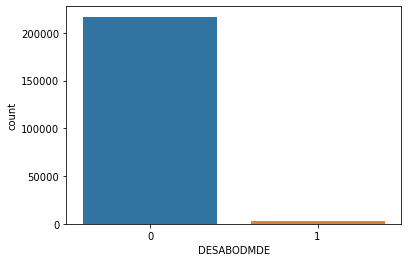

In [30]:
sns.countplot(data=df_contact_flag_desabo_anciennete, x="DESABODMDE", orient="v")

In [26]:
df_contact_flag_desabo_anciennete["DESABODMDE"] = df_contact_flag_desabo_anciennete["DESABODMDE"].astype(str)

In [ ]:
#px.bar(df_contact_flag_desabo_anciennete,x="DESABODMDE")

In [ ]:
pd.crosstab(df_test["INTER_MAIL_disc"],df_test["Tx_Ouverture_disc"],normalize=False,margins=True,margins_name="%Global")

In [ ]:
## création d'un type catégoriel

cat_type = CategoricalDtype(categories=["jamais_cib_mail","moins_3_mails","3_5_mails","5_8_mails","8_11_mails","11_16_mails","plus_16_mails"],
                           ordered=True)


In [ ]:
## Application du type

df_test["INTER_MAIL_disc"] = df_test["INTER_MAIL_disc"].astype(cat_type)

df_test = df_test.sort_values("INTER_MAIL_disc")

In [ ]:
## boite à moustache 

fig = px.box(df_test,x="INTER_MAIL_disc",y="Tx_Ouverture",
                   labels={"Tx_Ouverture":"Taux d'ouverture","INTER_MAIL_disc":"Classe d'email reçu"},
                   title="boxplot", 
             category_orders={"INTER_MAIL_disc":["1_3_mails","4_5_mails","6_8_mails","9_11_mails","12_16_mails","17_mails_et_plus","jamais_cib_mail"]})

fig.update_traces(boxmean=True)

fig.show()

In [ ]:
## boite à moustache

fig = px.box(df_test,x="INTER_MAIL_disc",y="Tx_Ouverture",
                   labels={"Tx_Ouverture":"Taux d'ouverture","INTER_MAIL_disc":"Classe d'email reçu"},
                   title="boxplot", 
             category_orders={"INTER_MAIL_disc":["1_3_mails","4_5_mails","6_8_mails","9_11_mails","12_16_mails","17_mails_et_plus","jamais_cib_mail"]})

fig.update_traces(boxmean=True)

fig.show()

Au premier abord, on constate un retressicement des boite à moustache au fur et à mesure que le nombre d'email reçu augmente. Plus on reçoit d'email, plus on a de chance d'ouvrir; donc taux minimum d'ouverture et le premier quartile des boites à moustaches se différentie au fur et à mesure que le nombre d'email reçu augmente. ce qui explique la diminution de l'écart inter quartile en fonction du nombre d'email reçu

50 % des adhérents qui reçoivent entre 3-5 mail ont un taux d'ouverture inférieur ou égal à 25%, et l'autre 50% ont un taux d'ouverture plutôt supérieur à ces 25%; et 75% de ces adhérents ont un taux d'ouverture inférieur à 75%, et sauf 25% ont un taux d'ouverture supérieur à 75%.

In [ ]:
fig = px.box(df_test,x="INTER_MAIL_bis_disc",y="Tx_Ouverture",#color="Tx_Clic/recu_disc",
                   labels={"INTER_MAIL_bis_disc":"Classe d'email reçu","Tx_Ouverture":"Taux d'ouverture"},
                   title="boxplot", 
             category_orders={"INTER_MAIL_bis_disc":["1_3_mails","4_mails","5_mails","6_8_mails","9_11_mails","12_16_mails","17_mails_et_plus","jamais_cib_mail"]})
fig.update_traces(boxmean=True)

fig.show()

In [123]:
df_test["Tx_Clic/recu_disc"].value_counts(normalize=True)

jamais_cliquer     0.885637
moins_20%_clic     0.081306
20_50%_clic        0.022083
plus_50%_clic      0.005546
jamais_cib_mail    0.005427
Name: Tx_Clic/recu_disc, dtype: float64

Text(0, 0.5, '')

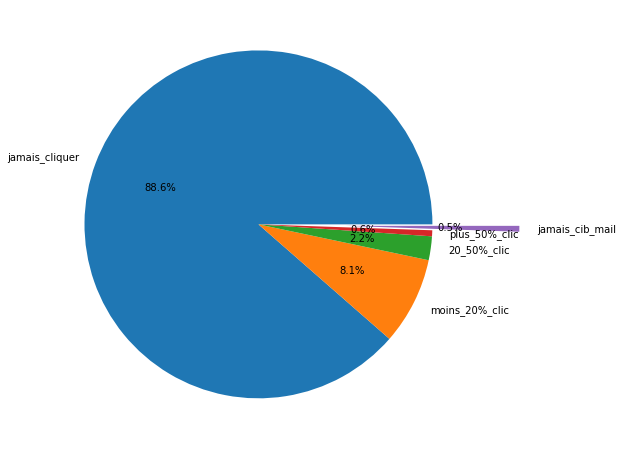

In [124]:
plt.figure(figsize=(10,8))

df_test["Tx_Clic/recu_disc"].value_counts(normalize=True).plot(kind='pie', autopct="%.1f%%"
            ,explode=[0,0,0,0,0.5])

plt.ylabel("")

In [ ]:
#px.area(df_contact_flag_desabo_anciennete, x="INTER_MAIL_disc", y="Tx_Ouverture")

fig = px.histogram(df_test,x="INTER_MAIL_disc",color="Tx_Clic/recu_disc",
                   labels={"INTER_MAIL_disc":"Classe d'email reçu","Tx_Ouverture_disc":"Taux ouverture discrétiser"},
                   title="",text_auto=True,histnorm ="percent",barnorm ="percent",
                  category_orders={"INTER_MAIL_disc":["1_3_mails","4_5_mails","6_8_mails","9_11_mails","12_16_mails","17_mails_et_plus","jamais_cib_mail"],
                                  "Tx_Ouverture_disc":["75_100%","50_75%","27_50%","11_27%","moins_11%","jamais_ouvert","jamais_cib_mail"]})

fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False, texttemplate='%{y:.2f}')

fig.show()

In [ ]:
pd.crosstab(df_test["INTER_MAIL_disc"],df_test["Tx_Ouverture_disc"])

In [ ]:
#df_test.loc[df_test["INTER_MAIL_disc"]=="moins_3_mails","Tx_Ouverture"].value_counts()

In [ ]:
#df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["INTER_MAIL_disc"]=="moins_3_mails","nb_open_email_delivre_36"].value_counts()

In [ ]:
fig = px.histogram(df_test_anc,x="INTER_MAIL_bis_disc",color="Tx_Ouverture_disc",
                   labels={"Tx_Ouverture_disc":"Classe de taux d'ouverture","INTER_MAIL_bis_disc":"Classe d'email reçu"},
                   title="histogramme",text_auto=True,histnorm ="percent",barnorm ="percent",
                  category_orders={"INTER_MAIL_bis_disc":["1_3_mails","4_mails","5_mails","6_8_mails","9_11_mails","12_16_mails","17_mails_et_plus","jamais_cib_mail"],
                                  "Tx_Ouverture_disc":["75_100%","50_75%","27_50%","11_27%","moins_11%","jamais_ouvert","jamais_cib_mail"]})

fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False, texttemplate='%{y:.2f}%')

fig.show()

In [150]:
20.69+22.38

43.07

In [116]:
## Export de l'ancienneté pour chaque NOIDE ce qui sera neccessaire pour le fichier "Test_Kolomogorov"

df_test_anc[["NOIDE","Anciennete"]].to_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\NOIDE_ANC")

In [ ]:
fig = px.histogram(df_test,x="Tx_Ouverture_disc",color="Tx_Clic/recu_disc",
                   labels={"count":"Nombre adhérent"},
                   title="Histogramme entre le Tx_Ouverture_disc et Tx_Clic/recu_disc",text_auto=True,histnorm ="percent",barnorm ="percent"
                   ,category_orders ={"Tx_Ouverture_disc":["moins_11%","11_27%","27_50%","50_75%","75_100%","jamais_ouvert"],
                                     "Tx_Clic/recu_disc":["plus_50%_clic","21_50%_clic","1_20%_clic","0%_clic","jamais_cliquer","jamais_cib_mail"]})

fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False, texttemplate='%{y:.2f}')

fig.show()

In [ ]:
fig = px.histogram(df_test_anc,x="INTER_MAIL_bis_disc",color="Tx_Clic/recu_disc",
                   labels={"Tx_Clic/recu_disc":"Classe Taux de clic sur email reçu","INTER_MAIL_bis_disc":"Classe d'email reçu"},
                   title="boxplot",text_auto=True,histnorm ="percent",barnorm ="percent",
                  category_orders={"INTER_MAIL_bis_disc":["1_3_mails","4_mails","5_mails","6_8_mails","9_11_mails","12_16_mails","17_mails_et_plus","jamais_cib_mail"],
                                  "Tx_Clic/recu_disc":["plus_50%_clic","20_50%_clic","moins_20%_clic","jamais_cliquer","jamais_cib_mail"]})

fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False, texttemplate='%{y:.2f}%')

fig.show()

In [157]:
15.05+16.49

31.54

In [ ]:
fig = px.histogram(df_test,x="INTER_MAIL_bis_disc",color="Tx_Clic/recu_disc",
                   labels={"count":"Nombre adhérent"},
                   title="Histogramme entre le Tx_Ouverture_disc et Tx_Clic/recu_disc",text_auto=True,histnorm ="percent",barnorm ="percent"
                   ,category_orders ={"INTER_MAIL_bis_disc":["moins_3_mails","4_mails","5_mails","6_8_mails","9_11_mails","12_16_mails","plus_16_mails","jamais_cib_mail"],
                                     "Tx_Clic/recu_disc":["plus_50%_clic","21_50%_clic","1_20%_clic","0%_clic","jamais_cliquer","jamais_cib_mail"]})

fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False, texttemplate='%{y:.2f}')

fig.show()

In [ ]:
fig = px.histogram(df_test,x="INTER_MAIL_disc",color="Tx_Clic/recu_disc",
                   labels={"count":"Nombre adhérent"},
                   title="boxplot",text_auto=True,histnorm ="percent",barnorm ="percent",
                  category_orders={})

fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False, texttemplate='%{y:.2f}')

fig.show()

In [ ]:
fig = px.histogram(df_test,x="Tx_Ouverture_disc",color="Tx_Clic/Ouvert_disc",
                   labels={"count":"Nombre adhérent"},
                   title="boxplot",text_auto=True,histnorm ="percent",barnorm ="percent"
                   ,category_orders ={"Tx_Ouverture_disc":["moins_11%","11_27%","27_50%","50_75%","75_100%","jamais_ouvert"],
                                     "Tx_Clic/Ouvert_disc":["plus_75%_clic/ouvert","51_75%_clic/ouvert","26_50%_clic/ouvert",
                                                           "1_25%_clic/ouvert","0%_clic/ouvert","jamais_ouvert/cliquer",
                                                           "jamais_cib_mail"]})

fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False, texttemplate='%{y:.2f}')

fig.show()

In [77]:
df_contact_flag_desabo_anciennete["Freq_moy_email/mois_disc"].value_counts(dropna=False)

1_mail/mois         1554844
ciblé_1_fois         157816
plus_2mails/mois      20717
Aucun_mail/mois       16081
Name: Freq_moy_email/mois_disc, dtype: int64

In [ ]:
fig = px.histogram(df_contact_flag_desabo_anciennete,x="Freq_moy_email/mois_disc",color="Tx_Ouverture_disc",
                   labels={"count":"Nombre adhérent"},
                   title="boxplot",text_auto=True,histnorm ="percent",barnorm ="percent",
                  category_orders={"INTER_MAIL_bis_disc":["ciblé_1_fois","1_mail/mois","plus_2mails/mois","Aucun_mail/mois"],
                                  "Tx_Ouverture_disc":["75_100%","50_75%","27_50%","11_27%","moins_11%","jamais_ouvert","jamais_cib_mail"]})

fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False, texttemplate='%{y:.2f}')

fig.show()

In [83]:
pd.crosstab(df_contact_flag_desabo_anciennete["Freq_moy_email/mois_disc"],
            df_contact_flag_desabo_anciennete["Tx_Ouverture_disc"], normalize="columns", margins=True)

Tx_Ouverture_disc,11_27%,27_50%,50_75%,75_100%,jamais_cib_mail,jamais_ouvert,moins_11%,All
Freq_moy_email/mois_disc,,,,,,,,
1_mail/mois,0.995636,0.986395,0.993887,0.835425,0.0,0.748976,0.997833,0.888758
Aucun_mail/mois,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.009192
ciblé_1_fois,0.000000,0.000219,0.000000,0.142146,0.0,0.236358,0.000000,0.090209
plus_2mails/mois,0.004364,0.013386,0.006113,0.022429,0.0,0.014665,0.002167,0.011842


In [28]:
[col for col in df_contact_flag_desabo_anciennete.columns if col.startswith('TOP')]

['TOP_ASSUR_VIE',
 'TOP_DECES',
 'TOP_CAM',
 'TOP_TOUT_HABITAT',
 'TOP_HABITAT_MGEN',
 'TOP_OBS',
 'TOP_PIM',
 'TOP_PROTECT_JURIQ',
 'TOP_RETRAITE',
 'TOP_SANTE_ANIM']

In [93]:
df_contact_flag_desabo_anciennete["Total_equip"] = df_contact_flag_desabo_anciennete[['TOP_ASSUR_VIE',
 'TOP_DECES',
 'TOP_CAM',
 'TOP_TOUT_HABITAT',
 'TOP_HABITAT_MGEN',
 'TOP_OBS',
 'TOP_PIM',
 'TOP_PROTECT_JURIQ',
 'TOP_RETRAITE',
 'TOP_SANTE_ANIM']].sum(axis=1)

df_contact_flag_desabo_anciennete["Total_equip"].value_counts()

(1749458, 122)

In [96]:
(df_contact_flag_desabo_anciennete[['TOP_ASSUR_VIE',
 'TOP_DECES',
 'TOP_CAM',
 'TOP_TOUT_HABITAT',
 'TOP_HABITAT_MGEN',
 'TOP_OBS',
 'TOP_PIM',
 'TOP_PROTECT_JURIQ',
 'TOP_RETRAITE',
 'TOP_SANTE_ANIM']].sum(axis=1)).value_counts(dropna=False)

0.0    1325498
1.0     266274
2.0     134607
3.0      21255
4.0       1666
5.0        145
6.0         13
dtype: int64

In [99]:
(134607+21255+1666+145+13)/1749458

0.09013420156414158

In [123]:
(df_contact_flag_desabo_anciennete["TOP_RETRAITE"]==1).sum()

141819

In [107]:
df_contact_flag_desabo_anciennete.head()

,NOIDE,DESABODMDE,INTER_COURRIER,INTER_SMS,INTER_MAIL,TOTAL_INTER_CANAL,Nb_SMS_delivre,Nb_email_delivre,nb_clic_email_delivre_36,First_open_email_delivre36_MOD,First_clic_email_delivre36,Latence_open_email_36_MOD,Latence_clic_email_36_MOD,recence_open_email_36_MOD,recence_clic_email_36_MOD,Nb_INTER_MAIL_AFTER_OPEN,Nb_INTER_MAIL_AFTER_CLIC,Nb_INTER_COURRIER_AVANT_DESAB,Nb_INTER_MAIL_AVANT_DESAB,Nb_INTER_SMS_AVANT_DESAB,Nb_TOTAL_EMAIL_SMS_AVANT_DESAB,Flag_desabo_2022,CODSEX,Anciennete,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,Latence_camp,First_INTER_CONTACT_ENTRANT_FORM,First_INTER_COURRIER,First_INTER_MAIL,First_INTER_SMS,First_INTER_TEL,First_Non_reçu,Last_INTER_CONTACT_ENTRANT_FORM,Last_INTER_COURRIER,Last_INTER_MAIL,Last_INTER_SMS,Last_INTER_TEL,Last_Non_reçu,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_Non_reçu,INTER_TEL,Appel_Non_reçu,Nbre_Total_Camp,Nbre_Camp_Conq,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Camp_Hors_Vente,Nbre_Camp_Vente,Age,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,Devis_Protect_Juriq,Devis_Sante_Animale,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nb_INTER_MAIL_AFTER_CLIC_MOD,Nb_Mail_avant_last_open_MoD,Nb_Mail_avant_last_clic_MoD,MIN_TEMPS_ECOULE_CONSE_CLIC,MAX_TEMPS_ECOULE_CONSE_CLIC,MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD,MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD,nb_open_email_delivre_36,Tx_Ouverture,Tx_Clic/recu,Tx_Clic/Ouvert,Tx_decroche,Freq_moy_email/mois,Freq_moy_Cour/mois,Freq_moy_SMS/mois,Freq_moy_TEL/mois,Freq_moy_Camp/mois,INTER_MAIL_disc,INTER_MAIL_bis_disc,INTER_TEL_disc,INTER_SMS_disc,INTER_COURRIER_disc,Total_Contact_disc,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,Nb_mail_last_open_disc,Tranche_anciennete,Tx_Ouverture_disc,Tx_decroche_disc,Nb_mail_last_clic_disc,Tx_Clic/Ouvert_disc,nb_clic_disc,nb_open_email_disc,Tx_Clic/recu_disc,MIN_TEMPS_ECOULE_CONSE_OUVERT_disc,MAX_TEMPS_ECOULE_CONSE_OUVERT_disc,MIN_TEMPS_ECOULE_CONSE_CLIC_disc,MAX_TEMPS_ECOULE_CONSE_CLIC_disc,recence_open_email_36_disc,recence_clic_email_36_disc
0,0100000001,0,0,0,2,2,0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,0,NaN,0,M,0.0,0.0,0.0,1,Plancher,783.0,132,NaN,NaN,2020-09-18,NaN,NaN,NaN,NaN,NaN,2021-01-28,NaN,NaN,NaN,132.0,NaN,NaN,NaN,NaN,0,0,2,0,2,0,2,0,69.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,0.0,331.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0,moins_3_mails,moins_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,1_mail/mois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,1_5_mail,moins_5ans,jamais_ouvert,jamais_cib_TEL,jamais_cliquer,jamais_ouvert/cliquer,Aucun_Clic,Aucun_open,jamais_cliquer,même_jr,plus_310_jrs,jamais_cliquer,jamais_cliquer,jamais_ouvert,jamais_ouvert
1,0100000272,1,0,0,1,1,0,1,0.0,2022-10-26,NaN,0.0,NaN,66.0,NaN,1.0,NaN,0,NaN,0,NaN,0,F,35.0,0.0,0.0,0,Forfait,393.0,0,NaN,NaN,2022-11-08,NaN,NaN,NaN,NaN,NaN,2022-11-08,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,207.0,1.0,100.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,inf,moins_3_mails,moins_3_mails,Aucun_Tel_dec,Aucun_SMS,Aucun_Cour,moins_3_cts,ciblé_1_fois,Aucun_Cour/mois,Aucun_SMS/mois,Aucun_TEL/mois,ciblé_1_fois,Aucun_mail,23_35ans,75_100%,jamais_cib_TEL,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,1_2_open,jamais_cliquer,même_jr,193_310_jrs,jamais_cliquer,jamais_cliquer,65_66_jrs,jamais_ouvert
2,0100002413,0,0,0,1,1,0,1,0.0,2022-10-26,NaN,0.0,NaN,66.0,NaN,1.0,NaN,0,NaN,0,NaN,0,F,31.0,0.0,0.0,0,Forfait,1092.0,0,NaN,NaN,2022-11-11,NaN,NaN,NaN,NaN,NaN,2022-11-11,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,N

In [125]:
#df_contact_flag_desabo_anciennete.to_pickle("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Etude_Pression_Com_Rel\Output_Files\df_anciennete")

In [119]:
df_contact_flag_desabo_anciennete[(df_contact_flag_desabo_anciennete["TOP_OBS"]==1)&(df_contact_flag_desabo_anciennete["COUVRE_BE"]==1)]

,NOIDE,DESABODMDE,INTER_COURRIER,INTER_SMS,INTER_MAIL,TOTAL_INTER_CANAL,Nb_SMS_delivre,Nb_email_delivre,nb_clic_email_delivre_36,First_open_email_delivre36_MOD,First_clic_email_delivre36,Latence_open_email_36_MOD,Latence_clic_email_36_MOD,recence_open_email_36_MOD,recence_clic_email_36_MOD,Nb_INTER_MAIL_AFTER_OPEN,Nb_INTER_MAIL_AFTER_CLIC,Nb_INTER_COURRIER_AVANT_DESAB,Nb_INTER_MAIL_AVANT_DESAB,Nb_INTER_SMS_AVANT_DESAB,Nb_TOTAL_EMAIL_SMS_AVANT_DESAB,Flag_desabo_2022,CODSEX,Anciennete,COUVRE_BE,COUVRE_BC,NB_RECLA,TYPE_COTISATION,MTT_COT_AN,Latence_camp,First_INTER_CONTACT_ENTRANT_FORM,First_INTER_COURRIER,First_INTER_MAIL,First_INTER_SMS,First_INTER_TEL,First_Non_reçu,Last_INTER_CONTACT_ENTRANT_FORM,Last_INTER_COURRIER,Last_INTER_MAIL,Last_INTER_SMS,Last_INTER_TEL,Last_Non_reçu,Latence_Mail,Latence_Cour,Latence_SMS,Latence_TEL,Latence_Non_reçu,INTER_TEL,Appel_Non_reçu,Nbre_Total_Camp,Nbre_Camp_Conq,Nbre_Camp_Fid,Nbre_Camp_Multiequip,Nbre_Camp_Hors_Vente,Nbre_Camp_Vente,Age,TOP_ASSUR_VIE,TOP_DECES,TOP_CAM,TOP_TOUT_HABITAT,TOP_HABITAT_MGEN,TOP_OBS,TOP_PIM,TOP_PROTECT_JURIQ,TOP_RETRAITE,TOP_SANTE_ANIM,Devis_Assur_Décès,Devis_Assur_Obs,Devis_Assur_Vie,Devis_CAM,Devis_Epargne_retraite,Devis_PIM,Devis_Protect_Juriq,Devis_Sante_Animale,PROPO_Courrier,PROPO_FACEAFACE,PROPO_INTERNET,PROPO_Mail,PROPO_TELEPHONE,Nb_INTER_MAIL_AFTER_CLIC_MOD,Nb_Mail_avant_last_open_MoD,Nb_Mail_avant_last_clic_MoD,MIN_TEMPS_ECOULE_CONSE_CLIC,MAX_TEMPS_ECOULE_CONSE_CLIC,MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD,MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD,nb_open_email_delivre_36,Tx_Ouverture,Tx_Clic/recu,Tx_Clic/Ouvert,Tx_decroche,Freq_moy_email/mois,Freq_moy_Cour/mois,Freq_moy_SMS/mois,Freq_moy_TEL/mois,Freq_moy_Camp/mois,INTER_MAIL_disc,INTER_MAIL_bis_disc,INTER_TEL_disc,INTER_SMS_disc,INTER_COURRIER_disc,Total_Contact_disc,Freq_moy_email/mois_disc,Freq_moy_Cour/mois_disc,Freq_moy_SMS/mois_disc,Freq_moy_TEL/mois_disc,Freq_moy_Camp/mois_disc,Nb_mail_last_open_disc,Tranche_anciennete,Tx_Ouverture_disc,Tx_decroche_disc,Nb_mail_last_clic_disc,Tx_Clic/Ouvert_disc,nb_clic_disc,nb_open_email_disc,Tx_Clic/recu_disc,MIN_TEMPS_ECOULE_CONSE_OUVERT_disc,MAX_TEMPS_ECOULE_CONSE_OUVERT_disc,MIN_TEMPS_ECOULE_CONSE_CLIC_disc,MAX_TEMPS_ECOULE_CONSE_CLIC_disc,recence_open_email_36_disc,recence_clic_email_36_disc
808,0100021527,0,2,0,2,5,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,NaN,0,NaN,0,F,34.0,1.0,0.0,0,Plafond,1773.00,1041,NaN,2020-01-24,2020-07-30,NaN,2022-01-07,2020-01-09,NaN,2021-01-18,2022-11-15,NaN,2022-01-07,2020-01-09,838.0,360.0,NaN,0.0,0.0,1,1,6,0,3,3,3,3,58.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,50.0,1.0,1.0,0.0,inf,1.0,moins_3_mails,moins_3_mails,Au_moins_1_tel_dec,Aucun_SMS,au_moins_1Cour,3_5_cts,1_mail/mois,plus_1_Cour/mois,Aucun_SMS/mois,ciblé_1_fois,1_Camp/mois,1_5_mail,23_35ans,jamais_ouvert,moins_50%,jamais_cliquer,jamais_ouvert/cliquer,Aucun_Clic,Aucun_open,jamais_cliquer,jamais_ouvert,jamais_ouvert,jamais_cliquer,jamais_cliquer,jamais_ouvert,jamais_ouvert
2152,0100030479,0,1,0,13,14,0,11,0.0,2020-12-11,NaN,0.0,NaN,750.0,NaN,10.0,NaN,0,NaN,0,NaN,0,F,30.0,1.0,0.0,0,Plafond,1773.00,1018,NaN,2020-01-24,2020-01-03,NaN,NaN,NaN,NaN,2020-01-24,2022-10-17,NaN,NaN,NaN,1018.0,0.0,NaN,NaN,NaN,0,0,14,0,11,3,11,3,55.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,171.0,1.0,8.0,0.0,0.0,NaN,1.0,inf,0.0,0.0,1.0,11_16_mails,12_16_mails,Aucun_Tel_dec,Aucun_SMS,au_moins_1Cour,12_17_cts,1_mail/mois,ciblé_1_fois,Aucun_SMS/mois,Aucun_TEL/mois,1_Camp/mois,1_5_mail,23_35ans,moins_11%,jamais_cib_TEL,jamais_cliquer,0%_clic/ouvert,Aucun_Clic,1_2_open,jamais_cliquer,1_jr,129_192_jrs,jamais_cliquer,jamais_cliquer,478_1094_jrs,jamais_ouvert
2177,0100030610,0,0,0,4,4,0,4,1.0,2022-05-11,2022-10-25,189.0,0.0,45.0,67.0,0.0,2.0,0,NaN,0,NaN,0,F,16.0,1.0,0.0,0,Taux,783.84,629,NaN,NaN,2022-05-18,NaN,NaN,2021-02-25,NaN,NaN,2022-11-16,NaN,NaN,202

In [111]:
#df_test_anc = df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Anciennete"]<=3].copy()

In [ ]:
fig = px.box(df_contact_flag_desabo_anciennete, x="Tx_Ouverture", color="CODSEX")

fig.update_traces(boxmean=True)

fig.show()

In [92]:
df_contact_flag_desabo_anciennete[["Age","INTER_MAIL","TOTAL_INTER_CANAL",
                                   "INTER_COURRIER","INTER_SMS","INTER_TEL","nb_clic_email_delivre_36",
                                  "nb_open_email_delivre_36"]].describe()

,Age,INTER_MAIL,TOTAL_INTER_CANAL,INTER_COURRIER,INTER_SMS,INTER_TEL,nb_clic_email_delivre_36,nb_open_email_delivre_36
count,1.627575e+06,1.749458e+06,1.749458e+06,1.749458e+06,1.749458e+06,1.749458e+06,1.660849e+06,1.660849e+06
mean,5.847527e+01,9.465596e+00,9.946318e+00,3.036169e-01,3.900065e-02,1.381045e-01,2.279870e-01,3.187785e+00
std,1.663650e+01,6.644618e+00,6.839260e+00,6.181603e-01,2.117564e-01,3.970710e-01,5.943958e-01,3.563460e+00
min,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.700000e+01,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.900000e+01,8.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,7.200000e+01,1.500000e+01,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
max,1.110000e+02,3.600000e+01,3.800000e+01,5.000000e+00,3.000000e+00,7.000000e+00,1.200000e+01,2.600000e+01


In [51]:
test = df_contact_flag_desabo_anciennete[['TOP_ASSUR_VIE',
 'TOP_DECES',
 'TOP_CAM',
 'TOP_TOUT_HABITAT',
 'TOP_HABITAT_MGEN',
 'TOP_OBS',
 'TOP_PIM',
 'TOP_PROTECT_JURIQ',
 'TOP_RETRAITE',
 'TOP_SANTE_ANIM']].agg(["value_counts"])

test.columns = test.columns.droplevel(1)

test = test.T.reset_index()

test.rename(columns={"index":"Equipement"}, inplace=True)

test

,Equipement,0.0,1.0
0,TOP_ASSUR_VIE,1623849,3726
1,TOP_DECES,1592791,34784
2,TOP_CAM,1592588,34987
3,TOP_TOUT_HABITAT,1432784,194791
4,TOP_HABITAT_MGEN,1504835,122740
5,TOP_OBS,1575625,51950
6,TOP_PIM,1606968,20607
7,TOP_PROTECT_JURIQ,1626464,1111
8,TOP_RETRAITE,1485756,141819
9,TOP_SANTE_ANIM,1627370,205


In [ ]:
px.histogram(test, x="Equipement",y=1.0, text_auto=True)

In [54]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=df_contact_flag_desabo_anciennete["TOP_ASSUR_VIE"], name="non_equipe",bingroup=1, histnorm="percent", histfunc="max"))

fig.add_trace(go.Histogram(x=df_contact_flag_desabo_anciennete["TOP_DECES"], name="equipe",bingroup=1,histnorm="percent", histfunc="max"))

fig.update_layout(
    barmode="group",
    bargap=0.1)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=test["Equipement"],y=test[0.0], name="non_equipe",bingroup=1, histnorm="percent", histfunc="max"))

fig.add_trace(go.Histogram(x=test["Equipement"],y=test[1.0], name="equipe",bingroup=1,histnorm="percent", histfunc="max"))

fig.update_layout(
    barmode="relative",
    bargap=0.1)

fig.show()

In [ ]:
def imputation_na(df, liste_col, col2="First_open_email_delivre36_MOD"):
    
    for col in liste_col:
        
        if df[col].isna().sum()>0:
    
            df.loc[df[col].isna()&df[col2].isna(), col+"_New"] = "NC"

            df[col+"_New"].fillna(df[col], inplace = True)

            df.drop(col, axis=1, inplace=True)
            
        else:
            
            continue
    
    return df


In [ ]:
df_contact_flag_desabo_anciennete["INTER_TEL"].value_counts(dropna=False).to_frame().head(30)

In [ ]:
#df_contact_flag_desabo_anciennete.columns

In [ ]:
## Gestion de la varible

pd.qcut(df_contact_flag_desabo_anciennete["INTER_TEL"],6, duplicates="drop")

In [ ]:
df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_disc"].value_counts(dropna=False)

In [ ]:
#df_contact_flag_desabo_anciennete["Nbre_Total_Camp"].value_counts(dropna=False)

In [ ]:
df_contact_flag_desabo_anciennete.columns

In [ ]:
df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["INTER_TEL"]==0]["Latence_TEL"].value_counts(dropna=False)

In [ ]:
df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["recence_clic_email_36_disc"].isna()]["First_clic_email_delivre36"].value_counts(dropna=False)

In [ ]:
df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Tx_decroche_disc"].isna()]["First_INTER_TEL"].value_counts(dropna=False)

In [ ]:
## On va remplacer une partie des NaN par "jamais_ouvert" pour les lugne ont la date d'ouverture n'est pas renseigné

df_contact_flag_desabo_anciennete.loc[df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc"].isna()&df_contact_flag_desabo_anciennete["First_open_email_delivre36_MOD"].isna(),"Nb_mail_last_clic_disc_MOD"] = "jamais_ouvert"

df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc_MOD"].fillna(df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc"], inplace=True)

## On va remplacer les Nan de la nouvelle colonne par "jamais_cliquer" car ceux là n'ont pas de date de clic renseigné



In [ ]:
df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD"].isna()]["First_clic_email_delivre36"].value_counts(dropna=False)

In [ ]:
df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert_disc"].value_counts(dropna=False)

In [ ]:
df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Nb_mail_last_clic_disc"].isna()&df_contact_flag_desabo_anciennete["First_open_email_delivre36_MOD"].isna()]#["Tx_Clic/Ouvert_disc"].value_counts(dropna=False)

In [ ]:
df_contact_flag_desabo_anciennete["CODSEX"].value_counts(dropna=False)

In [ ]:
imputation_na(df_contact_flag_desabo_anciennete,["Tx_Ouverture_disc","Tx_Clic/Ouvert","Latence_Mail","Nb_Mail_avant_last_open_MoD",
                                                "MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD","MAX_TEMPS_ECOULE_CONSE_OUVERT_MoD"])

In [ ]:
pd.qcut(df_contact_flag_desabo_anciennete["Tx_Ouverture"],6,duplicates="drop")        #.value_counts(dropna=False)

In [ ]:
pd.qcut(df_contact_flag_desabo_anciennete["Anciennete"],6, duplicates="drop")

In [ ]:
df_contact_flag_desabo_anciennete["Tx_Clic/Ouvert"].value_counts(dropna=False).to_frame().head(30)

In [ ]:
df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["MIN_TEMPS_ECOULE_CONSE_OUVERT_MoD"].isna() & df_contact_flag_desabo_anciennete["Tx_Ouverture"].isna()]["INTER_MAIL"].value_counts(dropna=False)

In [ ]:
df_contact_flag_desabo_anciennete.columns

In [ ]:
#df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_open"].isna()]

In [ ]:
#df_contact_flag_desabo_anciennete["Nb_Mail_avant_last_clic"].value_counts(dropna=False)

In [ ]:
## liste des colonnes discrétisées

liste_na = [col for col in df_contact_flag_desabo_anciennete.columns if df_contact_flag_desabo_anciennete[col].isna().sum()>0 and col.endswith("disc")]

drop_col(df_contact_flag_desabo_anciennete,liste_na[0])

drop_col(df_contact_flag_desabo_anciennete,liste_na[1])

Liste_disc = [col for col in df_contact_flag_desabo_anciennete.columns if col.endswith("disc") or col.endswith("disc_MoD")]

Liste_disc = Liste_disc + ["DESABODMDE","Flag_desabo_2022"]

Liste_disc

In [ ]:
df_contact_flag_desabo_anciennete["recence_open_email_36_MOD"].value_counts(dropna=False)

In [ ]:
407/30

In [ ]:
df_contact_flag_desabo_anciennete[Liste_disc].to_csv(r"C:\Users\pkamga\Documents\Etude_pression_Com\df_contact_flag_desabo_anciennete.csv",index=False)

In [ ]:
df_contact_flag_desabo_anciennete["Tx_Ouverture"].value_counts(dropna=False)

In [ ]:
pd.qcut(df_contact_flag_desabo_anciennete["Tx_Ouverture"],6, labels=["moins_10%", "10_16%","16_22%","22_33%","33_50%","50_100%"],duplicates="drop")

In [ ]:
yes = df_contact_flag_desabo_anciennete["Tx_Clic"].value_counts(dropna=False).to_frame()

yes.reset_index(inplace=True)

#yes.sort_values("index", inplace=True)

yes.head(50)

In [ ]:
df_contact_flag_desabo_anciennete[df_contact_flag_desabo_anciennete["Freq_moy_Cour/mois"]==np.inf].head()

In [ ]:
df_contact_flag_desabo_anciennete["INTER_MAIL"]*30/df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"]

In [ ]:
df_contact_flag_desabo_anciennete["Latence_clic_email_36_MOD"]/30

In [ ]:
sns.countplot(data=df_contact_flag_desabo_anciennete, x="INTER_MAIL",color="blue")#, y="nb_open_email_delivre_36_MOD")

sns.countplot(data=df_contact_flag_desabo_anciennete, x="nb_open_email_delivre_36_MOD",color="red")

plt.xlabel("nb_open_email_delivre_36_MOD/INTER_MAIL")

plt.ylabel("Nombre d'adhérents")

plt.show()

In [ ]:
plt.plot(df_contact_flag_desabo_anciennete["INTER_MAIL"],df_contact_flag_desabo_anciennete["nb_open_email_delivre_36_MOD"],
        linestyle = 'none', marker = 'o', c = 'lime')
plt.xlabel("INTER_MAIL")

plt.ylabel("nb_open_email_delivre_36_MOD")

plt.show()

In [ ]:
df_contact_flag_desabo_anciennete.columns

In [ ]:
df_contact_flag_desabo_anciennete[["INTER_COURRIER","INTER_SMS","INTER_MAIL","INTER_TEL","TOTAL_INTER_CANAL","Appel_Non_reçu"]]

In [ ]:
df_contact_flag_desabo_anciennete["INTER_TEL"].value_counts()